# ADA CAPI Notebook for Project Milestone 2

## Table of Contents:
The structure of this notebook is modeled on the outline of the one specified in the README.
1. Data Processing and Exploration
    1. Load Tabular Data
    2. Extracting metrics from textual articles
    3. Data Exploration
2. Data Analysis: Addressing the research subquestions
    1. Categories
    2. Analysing Article Metrics
    3. Path Difficulty
    4. Individual Player Behaviour
3. Data Analysis: Putting Everything Together
    


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import os
from scipy import stats

# Helper functions from utils folder
from utils.analysis import (
    t_test_article_metrics,
    visualize_article_connections_per_category,
    sorted_category_counts,
    shortest_path_find,
    simple_t_test,
)
from utils.preprocessing import (
    merge_articles_categories,
    create_category_dictionaries,
    filter_games,
    get_backclicked_pages,
)

# Formatting libraries
import urllib
import datetime as datetime

# Plotting libraries
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

default_colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# Imports to perform article analysis
import textstat
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")  # Punkt tokenizer
nltk.download("stopwords")  # Common stopwords

# Regression libraries
import statsmodels.formula.api as smf

# Stats libraries
from statistics import mean, median

# Load config and extract variables
import config


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import plotly.express as px

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

DATA_PATH = config.PATH_TO_DATA
PATH_GRAPH_FOLDER = config.PATH_GRAPH_FOLDER
ARTICLE_FOLDER = config.ARTICLE_FOLDER
GENERATED_METRICS = config.GENERATED_METRICS


[nltk_data] Downloading package punkt to /Users/mat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/mat/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="load"></a>
## 1 - Data Processing and Exploration

Note that you can load the data from [here](#checkpoint1).

<a id="tabu"></a>
### 1.1 - Tabular Data

In [2]:
# Load in all data (except wikipedia articles)
finished_paths = pd.read_csv(
    os.path.join(DATA_PATH, PATH_GRAPH_FOLDER, "paths_finished.tsv"),
    sep="\t",
    skiprows=15,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
)
unfinished_paths = pd.read_csv(
    os.path.join(DATA_PATH, PATH_GRAPH_FOLDER, "paths_unfinished.tsv"),
    sep="\t",
    skiprows=16,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
)
edges = pd.read_csv(
    os.path.join(DATA_PATH, PATH_GRAPH_FOLDER, "links.tsv"),
    sep="\t",
    skiprows=15,
    names=["start", "end"],
    encoding="utf-8",
)
articles = pd.read_csv(
    os.path.join(DATA_PATH, PATH_GRAPH_FOLDER, "articles.tsv"),
    sep="\t",
    skiprows=12,
    names=["article"],
    encoding="utf-8",
)
categories = pd.read_csv(
    os.path.join(DATA_PATH, PATH_GRAPH_FOLDER, "categories.tsv"),
    sep="\t",
    skiprows=13,
    names=["article", "category"],
    encoding="utf-8",
)
shortest_paths = np.genfromtxt(
    os.path.join(DATA_PATH, PATH_GRAPH_FOLDER, "shortest-path-distance-matrix.txt"),
    delimiter=1,
    dtype=np.uint8,
)

<a id="clean"></a>
#### Clean Tabular Data

In [3]:
# Clean up url encoding in edge list
display(edges.head())
edges["start"] = edges.start.apply(urllib.parse.unquote)
edges["end"] = edges.end.apply(urllib.parse.unquote)
display(edges.head())

,start,end
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney


,start,end
0,Áedán_mac_Gabráin,Great_Britain
1,Áedán_mac_Gabráin,Ireland
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Monarchy
4,Áedán_mac_Gabráin,Orkney


In [4]:
# Format datetime as datetime object
finished_paths["datetime"] = finished_paths.timestamp.apply(
    datetime.datetime.fromtimestamp
)
unfinished_paths["datetime"] = unfinished_paths.timestamp.apply(
    datetime.datetime.fromtimestamp
)
display(unfinished_paths.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type,datetime
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,2011-02-07 06:02:15
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,2011-02-07 06:14:11
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,2011-02-07 16:00:19
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2011-02-07 17:06:01
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2011-02-07 18:18:25


In [5]:
# Clean up url encoding for articles
display(articles.head())
articles["article"] = articles.article.apply(urllib.parse.unquote)
display(articles.head())

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [6]:
# Clean up url encoding for categories
display(categories.head())
categories["article"] = categories.article.apply(urllib.parse.unquote)
display(categories.head())

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [7]:
# Identify broad categories of articles
display(categories.head())
categories["broad_category"] = categories["category"].apply(
    lambda x: x.split(".")[1]
)  # first entry after subject.
display(categories.head())

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


,article,category,broad_category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...,History
1,Áedán_mac_Gabráin,subject.People.Historical_figures,People
2,Åland,subject.Countries,Countries
3,Åland,subject.Geography.European_Geography.European_...,Geography
4,Édouard_Manet,subject.People.Artists,People


In [8]:
# Merge articles and categories
articles_categories = pd.merge(articles, categories, how="left", on="article")
display(articles_categories.head())

# 6 articles without category!
print(
    "Merge introduced {} NAs in category columns:".format(
        articles_categories.category.isna().sum()
    )
)
articles_categories[articles_categories.category.isna()]

,article,category,broad_category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...,History
1,Áedán_mac_Gabráin,subject.People.Historical_figures,People
2,Åland,subject.Countries,Countries
3,Åland,subject.Geography.European_Geography.European_...,Geography
4,Édouard_Manet,subject.People.Artists,People


Merge introduced 6 NAs in category columns:


,article,category,broad_category
1360,Directdebit,NaN,NaN
1385,Donation,NaN,NaN
1811,Friend_Directdebit,NaN,NaN
3670,Pikachu,NaN,NaN
4342,Sponsorship_Directdebit,NaN,NaN
5141,Wowpurchase,NaN,NaN


In [9]:
# Convert paths to a readable format (lists) and remove url encoding
finished_paths["path"] = finished_paths["path"].apply(lambda x: x.split(";"))
finished_paths["path"] = finished_paths["path"].apply(
    lambda x: [urllib.parse.unquote(y) for y in x]
)

unfinished_paths["path"] = unfinished_paths["path"].apply(lambda x: x.split(";"))
unfinished_paths["path"] = unfinished_paths["path"].apply(
    lambda x: [urllib.parse.unquote(y) for y in x]
)

In [10]:
# Add start and target articles of path
finished_paths["start"] = [path[0] for path in finished_paths["path"]]
finished_paths["target"] = [path[-1] for path in finished_paths["path"]]

unfinished_paths["start"] = [path[0] for path in unfinished_paths["path"]]
unfinished_paths["target"] = unfinished_paths["target"].apply(urllib.parse.unquote)

<a id="gen"></a>

### 1.2 - Extracting metrics from textual articles

The code below was used to access the `plaintext_articles` folder and read all articles inside, creating a dataframe with all the metric information (see table below). To reduce runtime, we compute the article metrics once and then read the generated CSV file.


Article Metrics DataFrame Description:
| Metric             | Metric Name                  | Description                                                                                                   |
|-------------------------|-------------------------|---------------------------------------------------------------------------------------------------------------|
| `word_count`            | Total Word Count        | Represents the total word count in the article.                                                                |
| `stopword_count`        | Stopword Count          | Measures the number of words that do not contribute significantly to the content's meaning.                 |
| `stopword_percentage`   | Stopword Frequency      | Measures the percentage of words that do not contribute significantly to the content's meaning.                 |
| `non_stopword_count`    | Non-Stopword Count      | Measures the number of words that contribute to the content's meaning.                              |
| `non_stopword_percentage`| Non-Stopword Frequency  | Measures the percentage of words that contribute to the content's meaning.                              |
| `avg_word_length`       | Average Word Length     | Calculates the average word length (in characters) in the article.                                               |
| `avg_sent_length`       | Average Sentence Length | Calculates the average sentence length (in characters) in the article.                                               |
| `paragraph_count`       | Number of Paragraphs    | Calculates the total number of paragraphs in the article.                                                        |
| `common_words`          | Keyword Frequency       | Extracts the 10 most frequent of keywords.                  |
| `readability_score`     | Readability (Flesch Score)| Utilizes the Flesch Reading Ease Score for assessing readability. [Learn more](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests) |


In [11]:
def proprocess_article(article_text):
    """
    Lower casing and formatting line splits.
    :param article_text: Text of the article.
    :return: Preprocessed text of the article.
    """

    preprocessed_text = article_text
    preprocessed_text = preprocessed_text.lower()
    preprocessed_text = preprocessed_text.replace(
        "\n   ", " "
    )  # As the articles are not continuous sentences
    return preprocessed_text


def calculate_article_metrics(article_text):
    """
    Calculate article metrics for a given article.
    :param article_text: Text of the article.
    :return: Dictionary of article metrics.
    """

    preprocessed_text = proprocess_article(article_text)

    words = word_tokenize(preprocessed_text)
    sentences = sent_tokenize(preprocessed_text)

    # Calculate total word count
    total_word_count = len(words)

    # Calculate stopword frequency
    stop_words = set(stopwords.words("english"))
    stopwords_count = 0
    unique_words = []
    for word in words:
        if word.isalpha() and word.lower() in stop_words:
            stopwords_count += 1
        if word.isalpha() and word.lower() not in stop_words:
            unique_words.append(word.lower())

    # Calculate average word length
    average_word_length = sum(len(word) for word in words) / total_word_count

    # Calculate average sentence length
    average_sentence_length = sum(len(sentence) for sentence in sentences) / len(
        sentences
    )

    # Calculate number of paragraphs (assume every new line \n is paragraph)
    paragraphs_count = preprocessed_text.count("\n") + 1  # Count last paragraph

    # Calculate keyword frequency
    word_freq = nltk.FreqDist(unique_words)
    most_common_words = word_freq.most_common(10)  # Parameter to adjust

    # Calculate readability (Flesch Reading Ease Score) - 100: Easy to read, 0: Very confusing
    readability = textstat.flesch_reading_ease(preprocessed_text)

    return {
        "word_count": total_word_count,
        "non_stopword_count": total_word_count - stopwords_count,
        "non_stopword_percentage": (total_word_count - stopwords_count)
        / total_word_count,
        "stopword_count": stopwords_count,
        "stopword_percentage": stopwords_count / total_word_count,
        "avg_word_length": average_word_length,
        "avg_sent_length": average_sentence_length,
        "paragraph_count": paragraphs_count,
        "common_words": most_common_words,
        "readability_score": readability,
    }

In [12]:
# We do not run this code since it takes while, the output is saved in "/generated_data"

# folder_path = os.path.join(DATA_PATH, ARTICLE_FOLDER)
# if os.path.exists(folder_path) and os.path.isdir(folder_path):

#   article_metrics = pd.DataFrame(columns=["article", "word_count", "non_stopword_count", "non_stopword_percentage", "stopword_count", "stopword_percentage", "avg_word_length", "avg_sent_length", "paragraph_count", "common_words", "readability_score"])

#   for file_name in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, file_name)
    
#     if os.path.isfile(file_path):
#       root, extension = os.path.splitext(file_name)
#       readable_file_name = urllib.parse.unquote(root)
      
#       with open(file_path, "r", encoding="utf-8") as article:
#         metrics = calculate_article_metrics(article.read())

#         metrics["article"] = readable_file_name
#         article_metrics.loc[len(article_metrics)] = metrics
# else:
#   raise FileNotFoundError("The specified folder path does not exist or is not a directory.")

# article_metrics.to_csv(os.path.join(GENERATED_METRICS, "article_metrics.csv"), index=False)

Loading the article data (as mentioned before, this is done to reduce runtime)

In [13]:
article_metrics = pd.read_csv(os.path.join(GENERATED_METRICS, "article_metrics.csv"))

In [14]:
print(article_metrics.info())
display(article_metrics.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   article                  4604 non-null   object 
 1   word_count               4604 non-null   int64  
 2   non_stopword_count       4604 non-null   int64  
 3   non_stopword_percentage  4604 non-null   float64
 4   stopword_count           4604 non-null   int64  
 5   stopword_percentage      4604 non-null   float64
 6   avg_word_length          4604 non-null   float64
 7   avg_sent_length          4604 non-null   float64
 8   paragraph_count          4604 non-null   int64  
 9   common_words             4604 non-null   object 
 10  readability_score        4604 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 395.8+ KB
None


,article,word_count,non_stopword_count,non_stopword_percentage,stopword_count,stopword_percentage,avg_word_length,avg_sent_length,paragraph_count,common_words,readability_score
0,Second_Crusade,4901,2965,0.604979,1936,0.395021,4.348908,166.686275,59,"[('crusade', 45), ('louis', 39), ('conrad', 31...",63.83
1,Navassa_Island,1931,1365,0.706888,566,0.293112,4.614190,155.014493,32,"[('island', 56), ('navassa', 31), ('guano', 10...",54.73
2,Evan_Rachel_Wood,1213,815,0.671888,398,0.328112,4.469085,178.416667,32,"[('wood', 31), ('role', 10), ('roles', 7), ('f...",52.33
3,Tropical_Storm_Henri_(2003),1846,1347,0.729686,499,0.270314,4.584507,135.013514,39,"[('henri', 28), ('storm', 23), ('tropical', 21...",55.24
4,Final_Fantasy_Adventure,1371,899,0.655726,472,0.344274,4.429613,143.843137,33,"[('game', 25), ('final', 18), ('fantasy', 18),...",58.82


<a id="initial_exploration"></a>

### 1.3 - Initial Data Exploration

#### Path Lengths
Compare the path lengths between the finished and unfinished paths to detect potential outliers or trends that might influence the analysis.

In [15]:
# Calculate path lengths for finished paths and show summary statistics
finished_paths["path_length"] = finished_paths.path.apply(lambda el: len(el))
finished_paths["path_length"].describe()

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

In [16]:
# Calculate path lengths for unfinished paths and show summary statistics
unfinished_paths["path_length"] = unfinished_paths.path.apply(lambda el: len(el))
unfinished_paths["path_length"].describe()

count    24875.000000
mean         5.197789
std          5.772234
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        235.000000
Name: path_length, dtype: float64

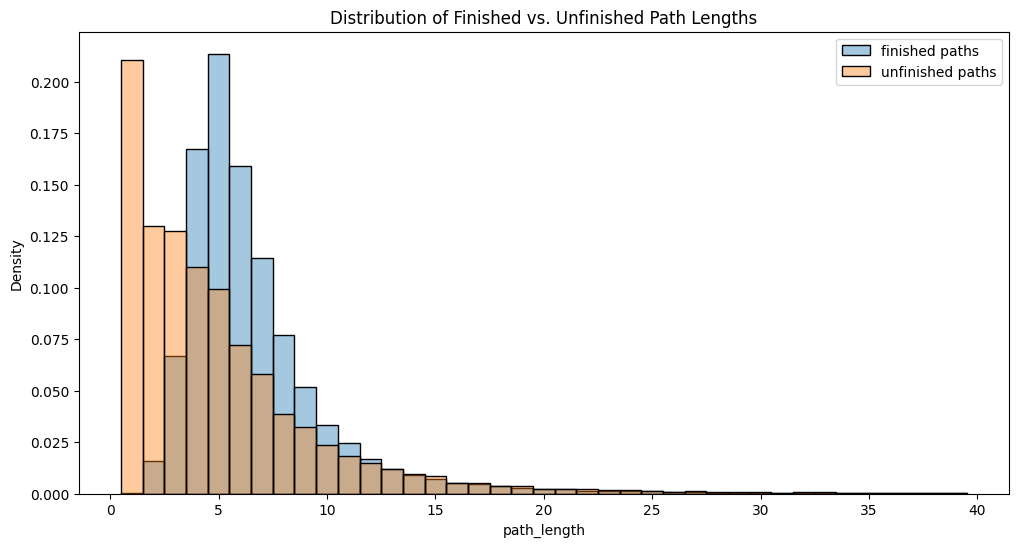

In [17]:
# Compare distributions of finished and unfinished paths
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
threshold = 40  # for now we remove some outliers to make the plots meaningful

# NOTE: plotting the density to compare the distributions (meaningful 0 length and 1 length paths?)
ax.set_title("Distribution of Finished vs. Unfinished Path Lengths")
sns.histplot(
    x=finished_paths.path_length[finished_paths.path_length < threshold],
    ax=ax,
    discrete=True,
    alpha=0.4,
    label="finished paths",
    stat="density",
    color=default_colors[0],
)
sns.histplot(
    x=unfinished_paths.path_length[unfinished_paths.path_length < threshold],
    ax=ax,
    discrete=True,
    alpha=0.4,
    label="unfinished paths",
    stat="density",
    color=default_colors[1],
)
plt.legend()
plt.show()

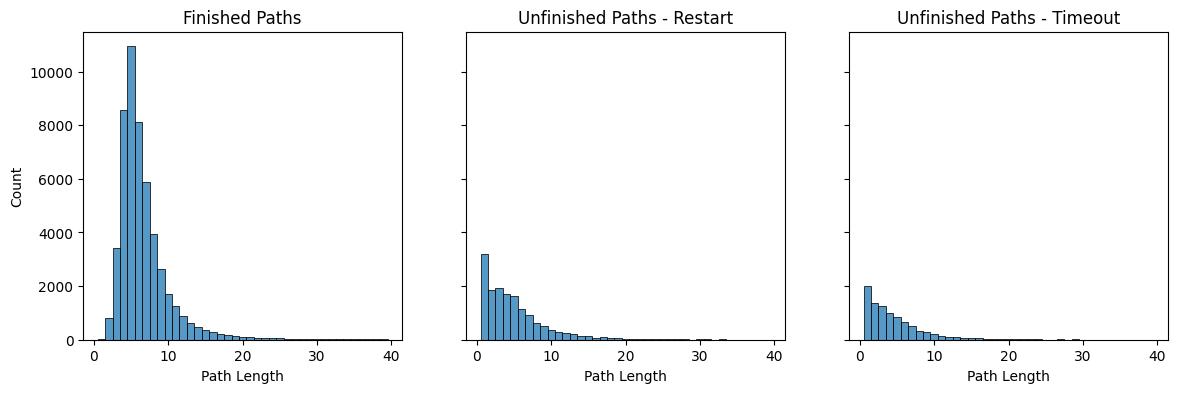

In [18]:
# Compare distributions of path lengths across finished, restarted paths and unfinished paths that timed out
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey=True)

sns.histplot(
    x=finished_paths.path_length[finished_paths.path_length < threshold],
    ax=axes[0],
    discrete=True,
    color=default_colors[0],
)
axes[0].set_title("Finished Paths")
axes[0].set_xlabel("Path Length")

unfinished_restart = unfinished_paths[
    (unfinished_paths.path_length < threshold) & (unfinished_paths.type == "restart")
]
sns.histplot(
    data=unfinished_restart,
    x="path_length",
    ax=axes[1],
    discrete=True,
    color=default_colors[0],
)
axes[1].set_title("Unfinished Paths - Restart")
axes[1].set_xlabel("Path Length")

unfinished_timeout = unfinished_paths[
    (unfinished_paths.path_length < threshold) & (unfinished_paths.type == "timeout")
]
sns.histplot(
    data=unfinished_timeout,
    x="path_length",
    ax=axes[2],
    discrete=True,
    color=default_colors[0],
)
axes[2].set_title("Unfinished Paths - Timeout")
axes[2].set_xlabel("Path Length")

plt.show()

#### Data across time

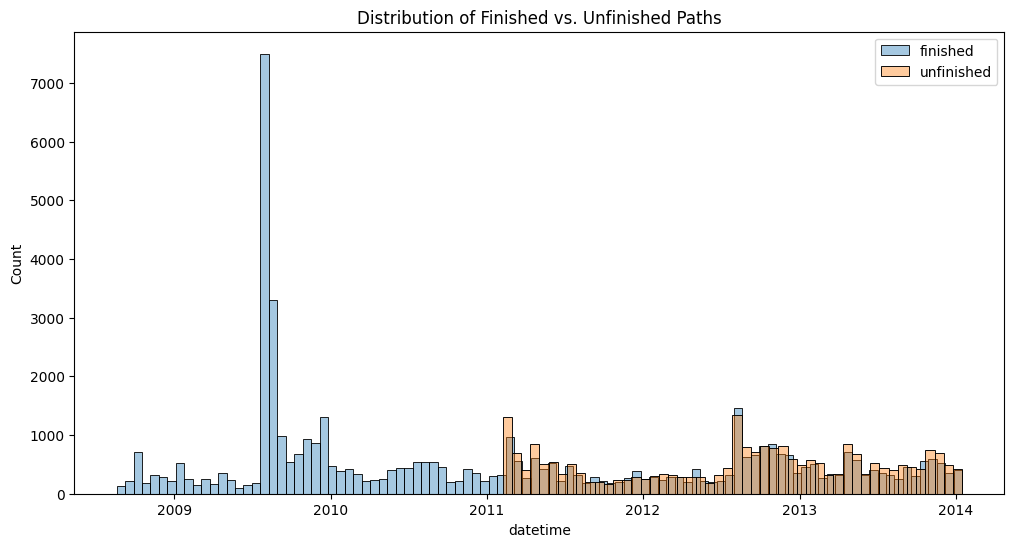

In [19]:
# Important note: unfinished paths before 2011 are missing
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title("Distribution of Finished vs. Unfinished Paths")
filter = lambda df, col: df[col]
sns.histplot(
    x=filter(finished_paths, "datetime"),
    ax=ax,
    alpha=0.4,
    label="finished",
    bins=100,
    color=default_colors[0],
)
sns.histplot(
    x=filter(unfinished_paths, "datetime"),
    ax=ax,
    alpha=0.4,
    label="unfinished",
    bins=50,
    color=default_colors[1],
)
plt.legend()
plt.show()

Unfinished paths before 2011 are not present in the dataset. It is crucial to keep this in mind for subsequent analyses on differences between finished and unfinished paths, since in some cases the results could change if we include all the paths or we exclude those before 2011.

#### Playing time (duration in seconds)

In [20]:
# Correct the duration in seconds
# Since the timeout is after 1800 seconds of inactivity, we consider here the correct duration
unfinished_timeout.loc[:, "effectiveDuration"] = unfinished_timeout["durationInSec"] - 1800

/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_44852/3632579987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unfinished_timeout.loc[:, "effectiveDuration"] = unfinished_timeout["durationInSec"] - 1800


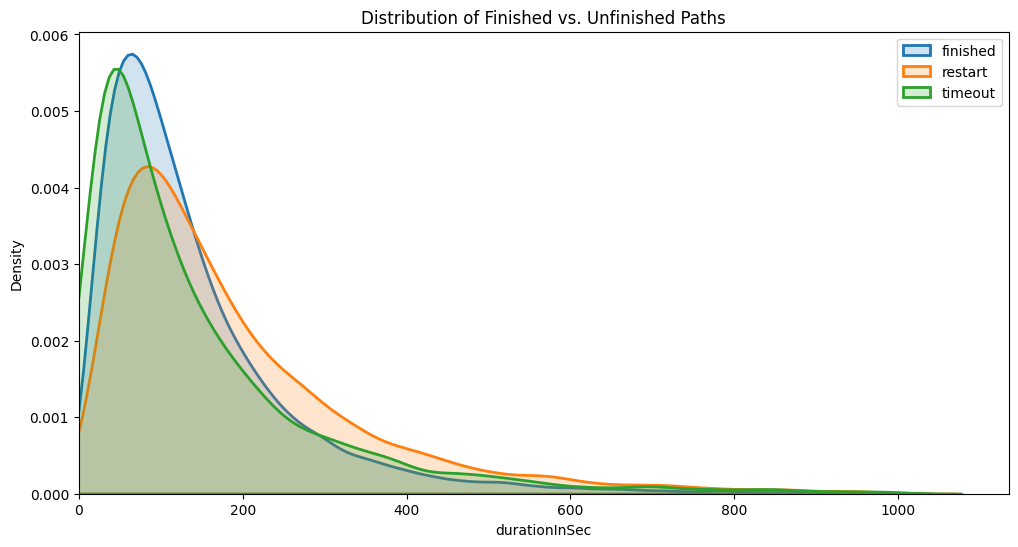

In [21]:
# compare the distributions of game duration
# different distribution for finished, restart and timeout
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title("Distribution of Finished vs. Unfinished Paths")
filter = lambda df, col: df[(df[col] >= 0) & (df[col] < 1000)][
    col
]  # chose 1000 for a better visualization
sns.kdeplot(
    x=filter(finished_paths, "durationInSec"),
    ax=ax,
    alpha=0.2,
    linewidth=2,
    fill=True,
    label="finished",
    color=default_colors[0],
)
sns.kdeplot(
    x=filter(unfinished_restart[unfinished_restart.path_length > 1], "durationInSec"),
    ax=ax,
    alpha=0.2,
    linewidth=2,
    fill=True,
    label="restart",
    color=default_colors[1],
)
sns.kdeplot(
    x=filter(
        unfinished_timeout[unfinished_timeout.path_length > 1], "effectiveDuration"
    ),
    ax=ax,
    alpha=0.2,
    linewidth=2,
    fill=True,
    label="timeout",
    color=default_colors[2],
)
ax.set_xlim(left=0)
plt.legend()
plt.show()

Note that we have some inconsistent values for `durationInSec`.

In [22]:
print(
    "{} paths are labeled as 'timeout' but their duration is below 1800 seconds (threshold for timeout)".format(
        len(
            unfinished_timeout["durationInSec"][
                unfinished_timeout["durationInSec"] < 1800
            ]
        )
    )
)

7 paths are labeled as 'timeout' but their duration is below 1800 seconds (threshold for timeout)


#### Distribution of target articles

Note also that there are few articles that are very often chosen as targets (or as start articles). 
This could also influence further analyses.

In [23]:
# Print articles' frequencies
# This is computed with respect to all (finished and unfinished) paths
target_counts = (
    unfinished_restart["target"].value_counts()
    + finished_paths["target"].value_counts()
    + unfinished_timeout["target"].value_counts()
).sort_values(ascending=False)

target_percentages = target_counts / target_counts.sum()

print("The 10 most frequent targets (frequency)")
display(target_percentages.head(10))

print("The 10 least frequent targets (frequency)")
display(target_percentages.sort_values(ascending=True).head(10))

The 10 most frequent targets (frequency)


target
Telephone            0.038187
Zebra                0.032165
Viking               0.031399
Bean                 0.028214
Adolf_Hitler         0.012131
Wood                 0.004839
Sun                  0.004769
God                  0.004264
Jesus                0.004108
Great_white_shark    0.004055
Name: count, dtype: float64

The 10 least frequent targets (frequency)


target
WorkChoices                            0.000070
Fermi_paradox                          0.000104
Lake_Burley_Griffin                    0.000104
Oregano                                0.000104
Tuvalu                                 0.000104
Giant's_Causeway                       0.000104
Soils_retrogression_and_degradation    0.000104
William_Wilberforce                    0.000104
Mount_Unzen                            0.000104
Mars_Reconnaissance_Orbiter            0.000104
Name: count, dtype: float64

In [24]:
# Print frequency of articles appearing as start articles
# This is computed with respect to all (finished and unfinished) paths
start_counts = (
    unfinished_restart["start"].value_counts()
    + finished_paths["start"].value_counts()
    + unfinished_timeout["start"].value_counts()
).sort_values(ascending=False)

start_percentages = start_counts / start_counts.sum()

print("The 10 most frequent targets (frequency)")
display(start_percentages.head(10))

print("The 10 least frequent targets (frequency)")
display(start_percentages.sort_values(ascending=True).head(10))

The 10 most frequent targets (frequency)


start
Brain       0.032683
Theatre     0.028197
Asteroid    0.027888
Pyramid     0.025135
Batman      0.014648
Cat         0.005707
Bird        0.005352
Dog         0.004331
Computer    0.003248
Beer        0.003047
Name: count, dtype: float64

The 10 least frequent targets (frequency)


start
Gaborone                        0.000046
Richard_III_(play)              0.000062
Haraldskær_Woman                0.000062
Tropical_Storm_Harvey_(2005)    0.000062
Côte_d'Ivoire                   0.000062
Lens_(anatomy)                  0.000062
California_Southern_Railroad    0.000062
Turkey_(bird)                   0.000062
GDRT                            0.000062
John_Tyler                      0.000062
Name: count, dtype: float64

<a id="analysis"></a>

## 2 - Data Analysis: Addressing the research subquestions

<a id="cats"></a>

### 2.1 - Categories

We want to look at the occurances of categories in the paths, to gain an understanding of whether certain categories lead to games that are on average easier for people.

#### 2.1.1 - Categories in Paths

In [25]:
# Seeing which categories are most represented in articles
count_articles = categories.groupby("broad_category").size()

print("Below shows how many articles each of the broad categories are represented by")
display(count_articles)

Below shows how many articles each of the broad categories are represented by


broad_category
Art                          38
Business_Studies             88
Citizenship                 224
Countries                   229
Design_and_Technology       254
Everyday_life               374
Geography                  1084
History                     545
IT                           85
Language_and_literature     196
Mathematics                  45
Music                        97
People                      689
Religion                    134
Science                    1122
dtype: int64

In [26]:
# Create dictionaries for easy discovery of what categories an article belongs to
article_to_category, article_to_broad_category = create_category_dictionaries(
    categories
)

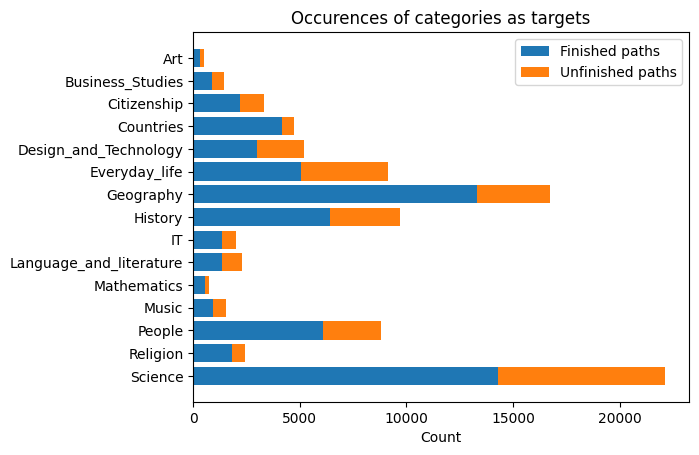

In [27]:
# Count how many times each category has occured as a target in the finished and unfinished paths.
# Note that some articles are represented by multiple categories, which are thus counted extra.

# Creating a dictionary of counts of the broad categories in the finished paths
sorted_cats_f = sorted_category_counts(finished_paths, article_to_broad_category)

# Creating a dictionary of counts of the broad categories in the unfinished paths
sorted_cats_u = sorted_category_counts(unfinished_paths, article_to_broad_category)

# Plotting the results.
ax = plt.barh(
    list(sorted_cats_f.keys()),
    sorted_cats_f.values(),
    label="Finished paths",
    color=default_colors[0],
)
ax2 = plt.barh(
    list(sorted_cats_u.keys()),
    sorted_cats_u.values(),
    left=list(sorted_cats_f.values()),
    label="Unfinished paths",
    color=default_colors[1],
)
plt.xlabel("Count")
plt.title("Occurences of categories as targets")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

The plot shows clearly that some categories occur as targets relatively more in finished paths while others have the opposite outcome. For example, "Couuntries" occurs as a target in finished paths multiple times as often as it does in unfinished paths, whereas "Everyday_life" occurs as a target in finished paths only slightly more often than it does in unfinished paths. 

The plot, however, also shows the imbalance in the categories. We have a lot of paths ending in "Geography" and "Science", but very few ending in "Mathematics" and "Art". We can create a plot with better interpretability regarding the influence of categories by charting the empirical likelihood of a target belonging to a certain category not being reached. This is the probability of a game being unfinished ($u$) for a given category $i$, and is calculated as:

$\Bbb{P}(u|i) = \frac{\text{num category i in unfinished paths target}}{\text{num category i in target}}$

However, a large part of the imbalance in the number of finished and unfinished paths comes from the fact that data on unfinished paths started to be collected only a couple of years after it did for finished paths. Thus, to have a probability value that makes sense, we need to exclude the finished path data from the time before data for unfinished paths also began to be collected. We will only perform this filtering for this particular analysis, however, as it results in a significant loss of data.

In [28]:
# Creating a dictionary of counts of the broad categories in the finished paths played after data began to be collected for unfinished paths.

finished_paths_post2011 = finished_paths[
    finished_paths["datetime"] >= unfinished_paths["datetime"].min()
]
sorted_cats_f_p2011 = sorted_category_counts(
    finished_paths_post2011, article_to_broad_category
)

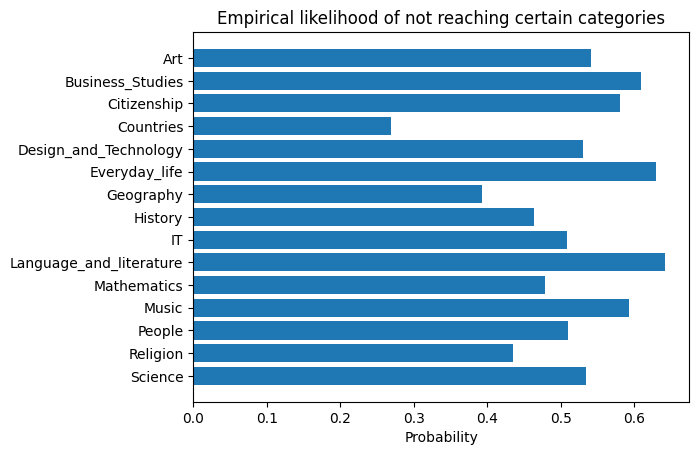

In [29]:
# Calculating the empirical likelihood that a target belonging to a certain category not being reached.
cat_unfinished_prob = {}
for i in sorted_cats_f:
    cat_unfinished_prob[i] = sorted_cats_u[i] / (
        sorted_cats_u[i] + sorted_cats_f_p2011[i]
    )

# Plotting the results.
ax = plt.barh(
    list(cat_unfinished_prob.keys()),
    cat_unfinished_prob.values(),
    color=default_colors[0],
)
plt.xlabel("Probability")
plt.title("Empirical likelihood of not reaching certain categories")
plt.gca().invert_yaxis()
plt.show()

This plot reinforces the possibility that certain categories make for easier games, as we can see that people are empirically more likely to not reach targets belonging to certain categories more than others.. Nonetheless, to establish a proper relationship, we may in the future need to control for certain other variables. For example, it could be that articles in the "Countries" category are simply better connected than those in the "Everyday_life" category. For this, we would need to potentially make use of matching and propensity scores to conduct a proper causal analysis.


<a id="sub"></a>

#### 2.1.2 - Exploring Subject Strength in Articles

Conducting an exploratory analysis on the relationship between categories of articles, our focus encompasses both neighboring articles (i.e., those directly connected by a link) and start/target articles in both finished and unfinished paths.

In [30]:
# Removing the 6 articles without category (found in section 1.2)!
articles_categories = articles_categories.dropna(subset=["broad_category"])

<a id="graph_cat"></a>

##### Exploring Subject Strength in Connected Articles
Visualizing the strength of the categories for connected articles (those which are connected by an edge).

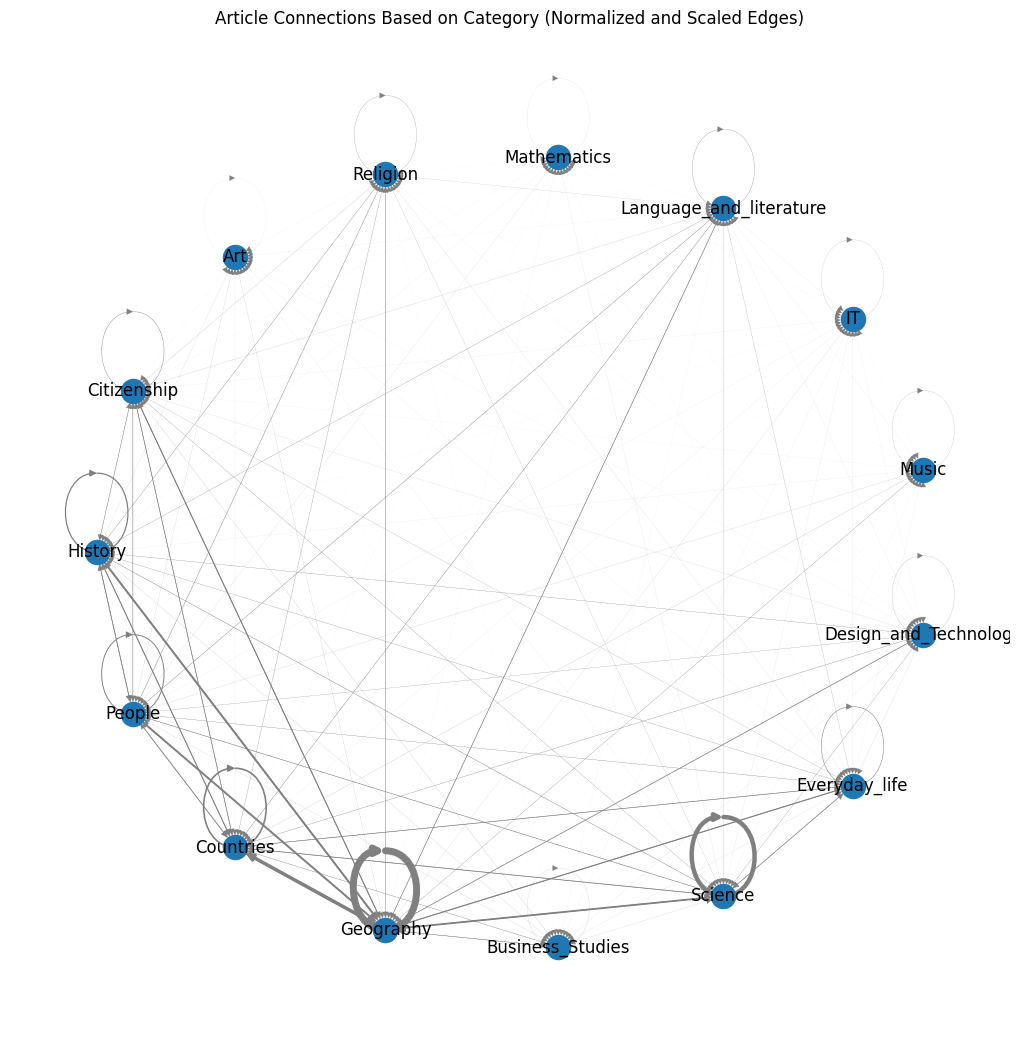

(<networkx.classes.digraph.DiGraph at 0x2b63db6d0>,
 [0.17691390615685942,
  0.8981946691646087,
  0.7708847824235715,
  0.2392914928042238,
  1.4116920718726051,
  0.08749893553606404,
  0.479434556757217,
  0.13646427659030913,
  0.09665332538533594,
  0.09069232734394958,
  0.008941497062079537,
  0.020437707570467513,
  0.04428169973601294,
  0.009367282636464276,
  0.006386783615771097,
  0.4781572000340628,
  0.14987652218342842,
  0.6367623264923784,
  1.4023247892361406,
  0.19628714979136508,
  0.6889210593545091,
  0.2752703738397343,
  0.18670697436770842,
  0.2967725453461637,
  0.04300434301285873,
  0.08196372306906242,
  0.04385591416162821,
  0.03235970365324023,
  0.014476709529081155,
  0.027888955122200458,
  0.2522779528229584,
  1.7376309290641234,
  1.1755939708762666,
  0.26803201907519375,
  0.1217746742740356,
  0.13582559822873203,
  0.17265605041301202,
  0.12347781657157456,
  0.09942093161883675,
  0.09026654176956485,
  0.014263816741888785,
  0.0040449629

In [31]:
# Merging the category information to the articles in the edges dataframe
edge_category = merge_articles_categories(edges, ["start", "end"], articles_categories)

# Visualizing their article relations through categories in a graph
visualize_article_connections_per_category(
    edge_category,
    articles_categories,
    "Article Connections Based on Category (Normalized and Scaled Edges)",
)

<a id="graph_cat_fi"></a>

##### Exploring Subject Strength in Finished Path Articles
Visualizing the strength of the categories for both start and target articles in the finished paths using a graph.

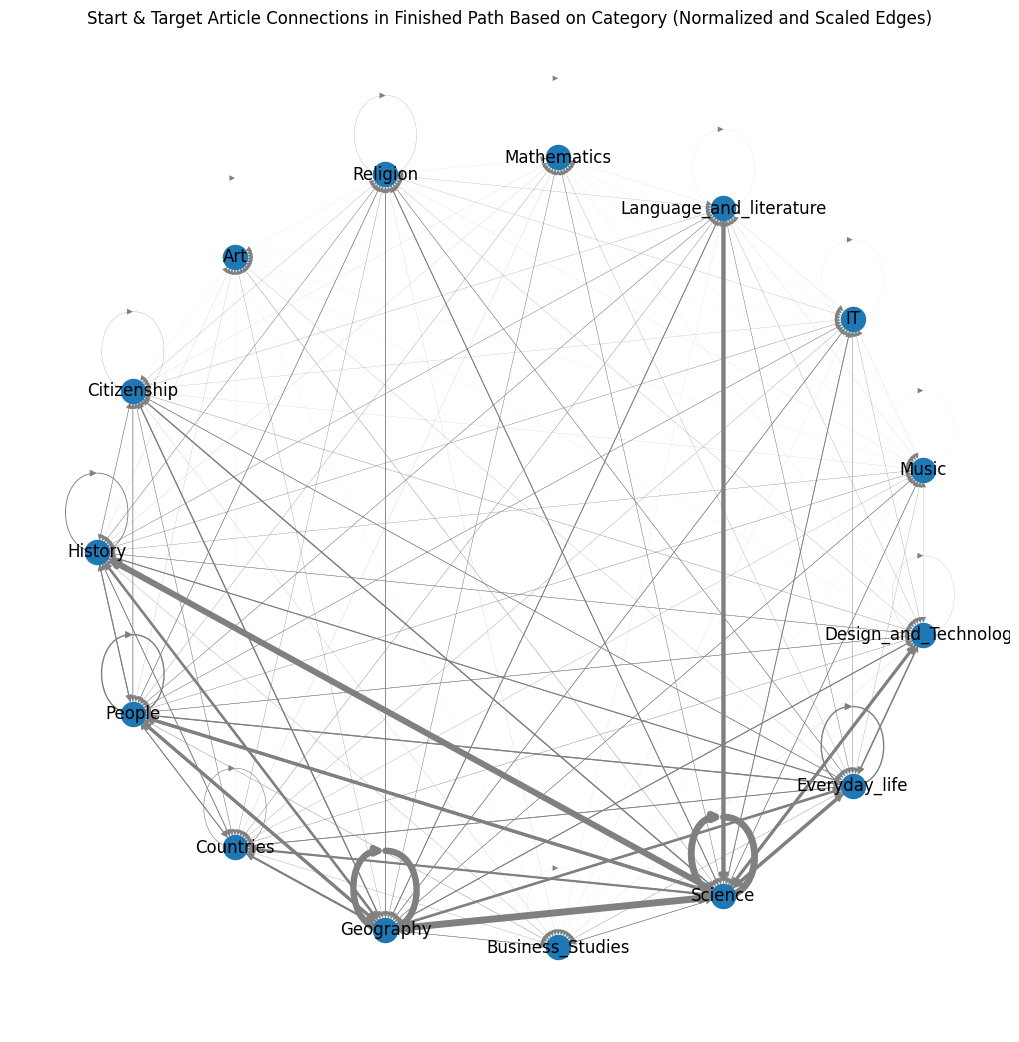

(<networkx.classes.digraph.DiGraph at 0x2a94f6d90>,
 [1.8165367483296213,
  0.3048440979955457,
  0.0779510022271715,
  0.6570155902004454,
  0.5066815144766147,
  0.7391425389755012,
  0.558184855233853,
  1.5798997772828507,
  0.05846325167037862,
  0.2547327394209354,
  0.10857461024498886,
  0.04593541202672606,
  0.16842984409799555,
  0.2797884187082405,
  0.1517260579064588,
  2.3733296213808464,
  1.0342427616926502,
  0.14337416481069043,
  0.7099109131403119,
  2.079621380846325,
  0.311804008908686,
  0.34103563474387527,
  0.6417037861915367,
  0.7196547884187082,
  0.3257238307349666,
  0.22410913140311806,
  0.2644766146993318,
  0.16842984409799555,
  0.09743875278396437,
  0.05567928730512249,
  0.3772271714922049,
  0.4217706013363029,
  0.11692650334075724,
  1.0091870824053453,
  1.2680957683741647,
  0.400890868596882,
  0.47048997772828505,
  0.08212694877505568,
  0.16425389755011136,
  0.13502227171492204,
  0.10439866369710468,
  0.08630289532293986,
  0.0292316

In [32]:
# Merging the category information to the articles in the finished_paths dataframe
finished_paths_categories = merge_articles_categories(
    finished_paths, ["start", "target"], articles_categories
)

# Visualizing their article relations through categories in a graph
visualize_article_connections_per_category(
    finished_paths_categories,
    articles_categories,
    "Start & Target Article Connections in Finished Path Based on Category (Normalized and Scaled Edges)",
)

<a id="graph_cat_unfi"></a>

##### Exploring Subject Strength in Uninished Path Articles
Visualizing the strength of the categories for both start and target articles in the unfinished paths using a graph.

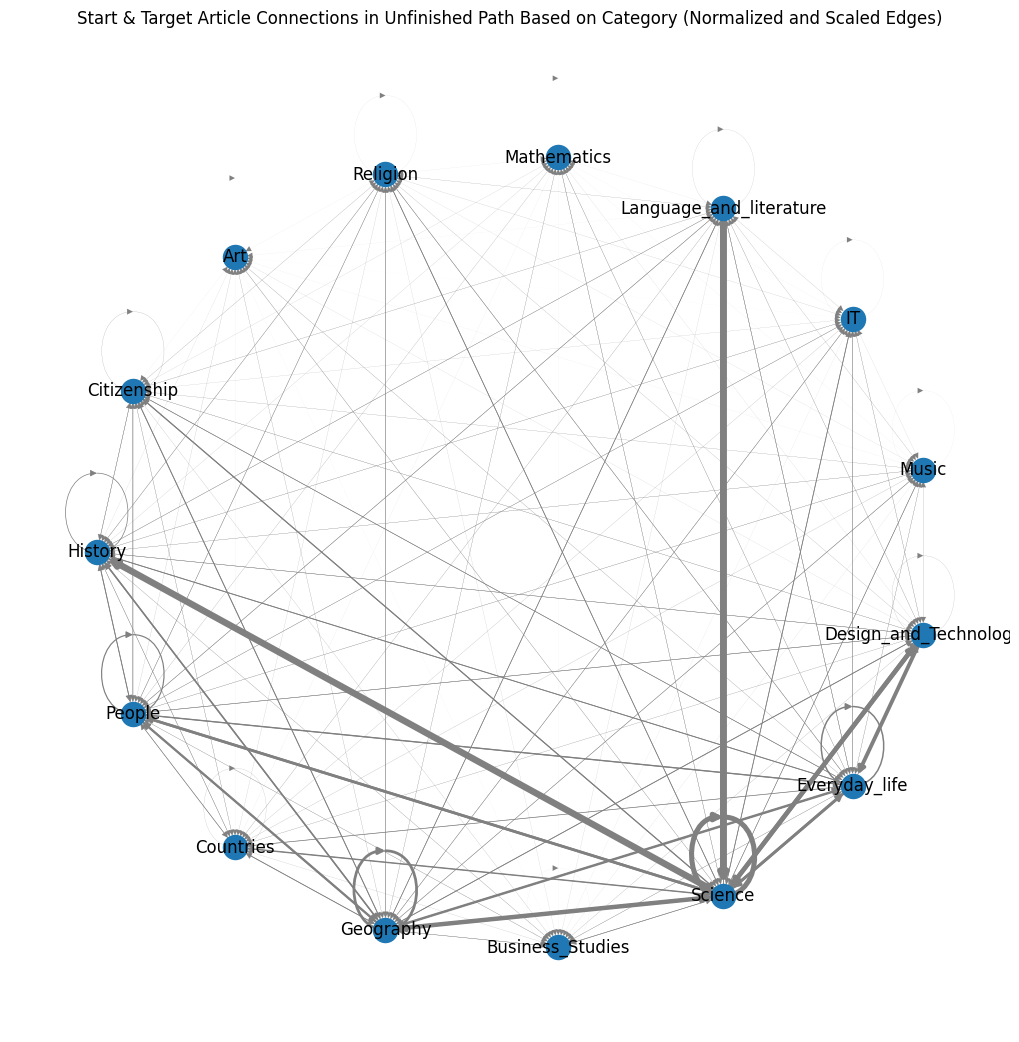

(<networkx.classes.digraph.DiGraph at 0x2b7765f10>,
 [0.600997506234414,
  0.9052369077306733,
  1.4588528678304238,
  0.658354114713217,
  0.26184538653366585,
  0.17456359102244387,
  0.13216957605985039,
  0.13216957605985039,
  0.5187032418952618,
  0.20698254364089774,
  0.12718204488778054,
  0.1571072319201995,
  0.24937655860349128,
  0.04239401496259351,
  0.029925187032418952,
  1.9501246882793017,
  1.0947630922693268,
  0.5511221945137157,
  0.2967581047381546,
  0.855361596009975,
  0.16458852867830426,
  0.2718204488778055,
  0.9476309226932668,
  0.16209476309226933,
  0.18204488778054861,
  0.20947630922693267,
  0.18703241895261846,
  0.27930174563591026,
  0.03740648379052369,
  0.05735660847880299,
  0.44139650872817954,
  0.26932668329177056,
  0.14214463840399003,
  1.0349127182044886,
  0.054862842892768084,
  0.5960099750623441,
  0.09975062344139651,
  0.18703241895261846,
  0.49875311720698257,
  0.0972568578553616,
  0.07231920199501247,
  0.07231920199501247,

In [33]:
# Merging the category information to the articles in the unfinished_paths dataframe
unfinished_paths_categories = merge_articles_categories(
    unfinished_paths, ["start", "target"], articles_categories
)

# Visualizing their article relations through categories in a graph
visualize_article_connections_per_category(
    unfinished_paths_categories,
    articles_categories,
    "Start & Target Article Connections in Unfinished Path Based on Category (Normalized and Scaled Edges)",
)

<a id="artmet"></a>

### 2.2 - Article Metrics

Conducting an analysis on the article metrics extracted in section 2.1. 

<a id="artmet_cat"></a>

##### 2.2.1 - Analysing Article Metrics by Category

Viewing how the different metrics (e.g., word_count, stopword_count, etc.) vary across different categories of articles. These differences are evident by visualizing the metrics in both bar plots and violin plots (see below).

In [34]:
# Merge articles with their corresponding categories
article_metrics_with_categories = article_metrics.merge(
    categories, how="left", on=["article"]
)
display(article_metrics_with_categories.head())

,article,word_count,non_stopword_count,non_stopword_percentage,stopword_count,stopword_percentage,avg_word_length,avg_sent_length,paragraph_count,common_words,readability_score,category,broad_category
0,Second_Crusade,4901,2965,0.604979,1936,0.395021,4.348908,166.686275,59,"[('crusade', 45), ('louis', 39), ('conrad', 31...",63.83,subject.History.Military_History_and_War,History
1,Second_Crusade,4901,2965,0.604979,1936,0.395021,4.348908,166.686275,59,"[('crusade', 45), ('louis', 39), ('conrad', 31...",63.83,subject.Religion.Religious_disputes,Religion
2,Navassa_Island,1931,1365,0.706888,566,0.293112,4.614190,155.014493,32,"[('island', 56), ('navassa', 31), ('guano', 10...",54.73,subject.Geography.North_American_Geography,Geography
3,Evan_Rachel_Wood,1213,815,0.671888,398,0.328112,4.469085,178.416667,32,"[('wood', 31), ('role', 10), ('roles', 7), ('f...",52.33,subject.People.Actors_models_and_celebrities,People
4,Tropical_Storm_Henri_(2003),1846,1347,0.729686,499,0.270314,4.584507,135.013514,39,"[('henri', 28), ('storm', 23), ('tropical', 21...",55.24,subject.Geography.Storms,Geography


/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_44852/928971162.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_44852/928971162.py:22: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_44852/928971162.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=90)
/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_44852/928971162.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.vi

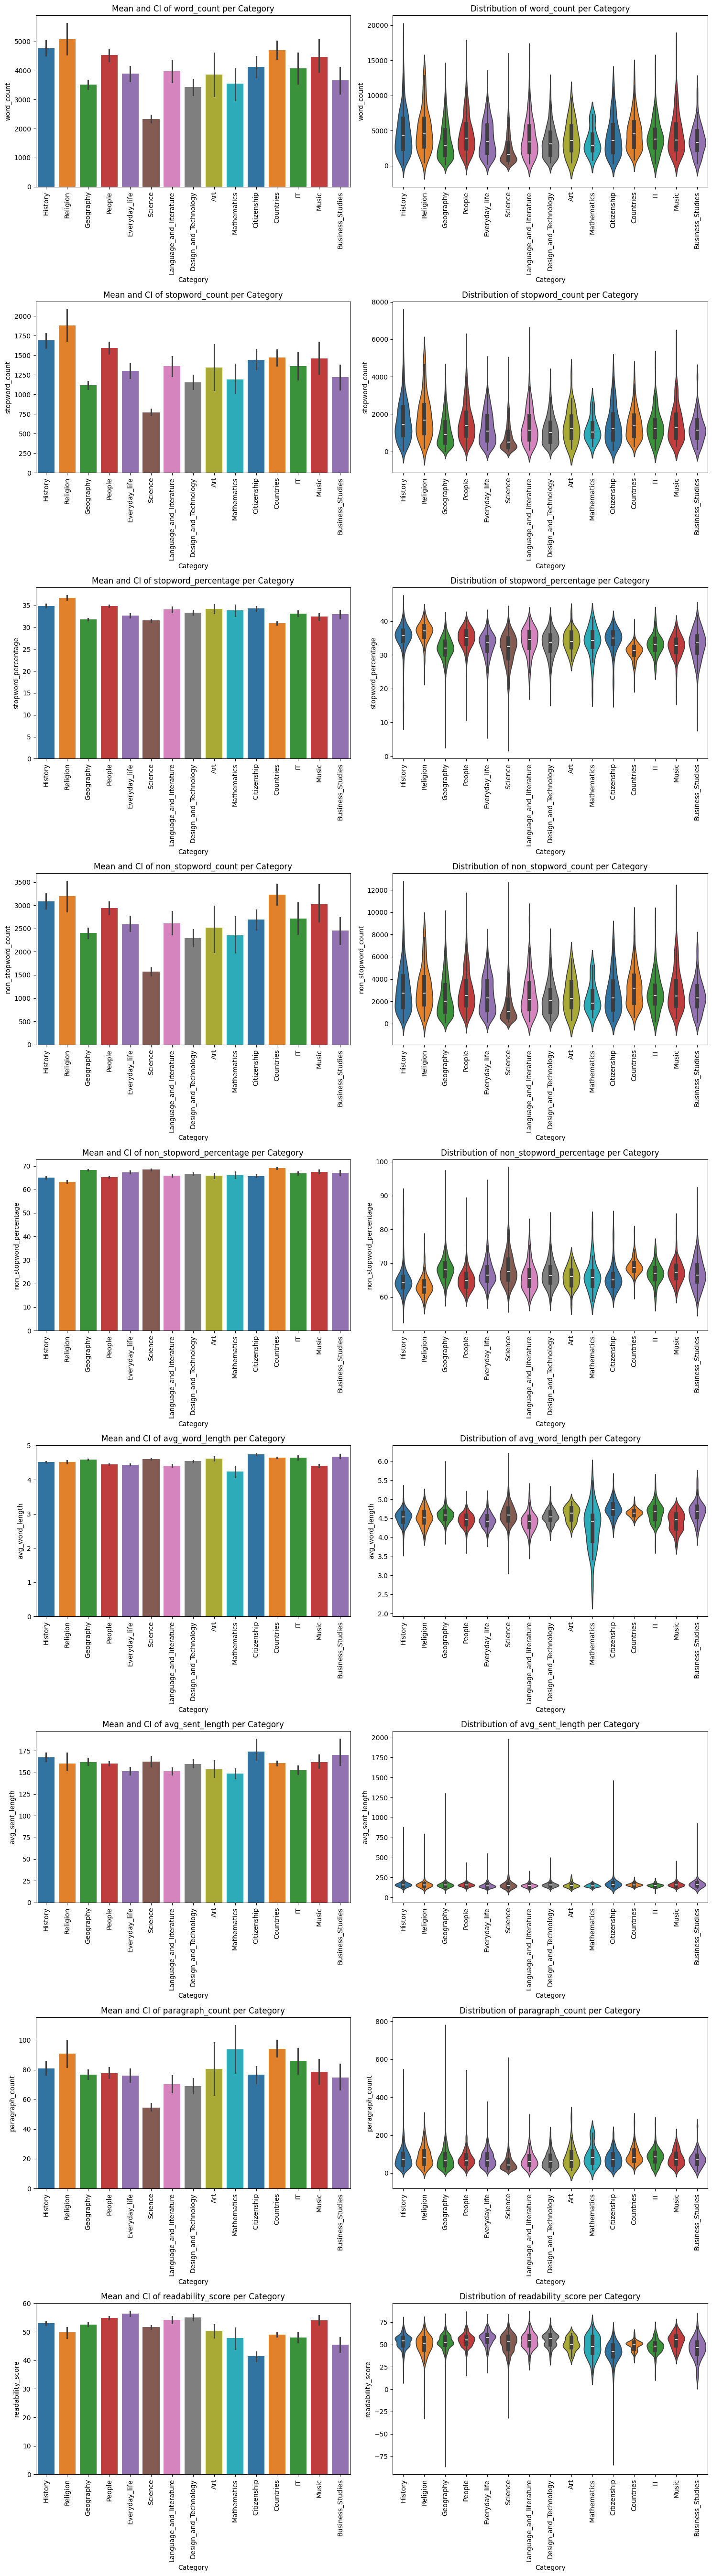

In [35]:
metrics_to_plot = [
    "word_count",
    "stopword_count",
    "stopword_percentage",
    "non_stopword_count",
    "non_stopword_percentage",
    "avg_word_length",
    "avg_sent_length",
    "paragraph_count",
    "readability_score",
]
fig, axes = plt.subplots(
    nrows=len(metrics_to_plot), ncols=2, figsize=(15, 6 * len(metrics_to_plot))
)

article_metrics_with_categories["stopword_percentage"] = 100 * article_metrics_with_categories["stopword_percentage"]
article_metrics_with_categories["non_stopword_percentage"] = 100 * article_metrics_with_categories["non_stopword_percentage"]

for idx, metric in enumerate(metrics_to_plot):
    # Bar plot
    ax_bar = axes[idx, 0]
    sns.barplot(
        x=article_metrics_with_categories["broad_category"],
        y=article_metrics_with_categories[metric],
        errorbar=("ci", 95),
        ax=ax_bar,
        palette=default_colors,
    )
    ax_bar.set_xlabel("Category")
    ax_bar.set_ylabel(metric)
    ax_bar.set_title("Mean and CI of {} per Category".format(metric))
    ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=90)

    # Violin plot
    ax_violin = axes[idx, 1]
    sns.violinplot(
        x=article_metrics_with_categories["broad_category"],
        y=article_metrics_with_categories[metric],
        ax=ax_violin,
        palette=default_colors,
    )
    ax_violin.set_xlabel("Category")
    ax_violin.set_ylabel(metric)
    ax_violin.set_title("Distribution of {} per Category".format(metric))
    ax_violin.set_xticklabels(ax_violin.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

Some observations:
* Interesting observations from the plot reveal that science articles generally tend to be shorter in length, evident in lower word counts and paragraph counts.
* Mathematical article appear to be the least consistent in word length, with a notable high variance.
* Articles related to countries, on average, display the lowest proportion of stopwords (percentage-wise), suggesting they might posses a rich vocabulary.

<a id="artmetfu_path"></a>

##### 2.2.2 - Analysing Article Metrics in Finished vs Unfinished paths

Viewing how the different metrics (e.g., word_count, stopword_count, etc.) vary across start/target articles in finished/unfinished paths. Both bar plots and violin plots are used to understand the distribution our these metrics. We observe remarkable similarity accross all plots, but minor differences are apparent in word count and paragraph count.

In [36]:
# Show the article metrics per finished and unfinished parths (both for start and end articles)
start_finished_article_metrics = finished_paths.merge(
    article_metrics_with_categories, how="left", left_on="start", right_on="article"
)
end_finished_article_metrics = finished_paths.merge(
    article_metrics_with_categories, how="left", left_on="target", right_on="article"
)
start_unfinished_article_metrics = unfinished_paths.merge(
    article_metrics_with_categories, how="left", left_on="start", right_on="article"
)
end_unfinished_article_metrics = unfinished_paths.merge(
    article_metrics_with_categories, how="left", left_on="target", right_on="article"
)

In [ ]:
metrics_to_plot = [
    "word_count",
    "stopword_count",
    "stopword_percentage",
    "non_stopword_count",
    "non_stopword_percentage",
    "avg_word_length",
    "avg_sent_length",
    "paragraph_count",
    "readability_score",
]
dataframes = [
    start_finished_article_metrics,
    start_unfinished_article_metrics,
    end_finished_article_metrics,
    end_unfinished_article_metrics,
]
dataframe_labels = [
    "Start Finished",
    "Start Unfinished",
    "Target Finished",
    "Target Unfinished",
]

fig, axes = plt.subplots(
    nrows=len(metrics_to_plot), ncols=2, figsize=(15, 6 * len(metrics_to_plot))
)

for idx, metric in enumerate(metrics_to_plot):
    data = [df[metric] for df in dataframes]

    # Bar plot
    ax_bar = axes[idx, 0]
    sns.barplot(data=data, errorbar=("ci", 95), ax=ax_bar, palette=default_colors)
    ax_bar.set_xlabel("Type of article")
    ax_bar.set_ylabel(metric)
    ax_bar.set_title("Mean and CI of {} per Category".format(metric))
    ax_bar.set_xticklabels(dataframe_labels)

    # Violin plot
    ax_violin = axes[idx, 1]
    sns.violinplot(data=data, ax=ax_violin, palette=default_colors)
    ax_bar.set_xlabel("Type of article")
    ax_violin.set_ylabel(metric)
    ax_violin.set_title("Distribution of {} per Category".format(metric))
    ax_violin.set_xticklabels(dataframe_labels)

plt.tight_layout()
plt.show()

In [ ]:
# Comparing article metric differences in starting articles in finished/unfinished paths.
print("Start Articles (comparing finished vs unfinished):")
t_test_article_metrics(
    metrics_to_plot, start_finished_article_metrics, start_unfinished_article_metrics
)

# Comparing article metric differences in target articles in finished/unfinished paths.
print("\nTarget Articles (comparing finished vs unfinished):")
t_test_article_metrics(
    metrics_to_plot, end_finished_article_metrics, end_unfinished_article_metrics
)


# Comparing article metric differences in (start, target) article pairs in finished/unfinished paths.
# This enables us to identify differences between the articles one starts with and those that need to be finished
# in both finished/unfinished paths, aiming to uncover potential factors that might impact the player.
print("\nFinished Articles (comparing start vs target):")
t_test_article_metrics(
    metrics_to_plot, start_finished_article_metrics, end_finished_article_metrics
)

print("\nUnfinished Articles (comparing start vs target):")
t_test_article_metrics(
    metrics_to_plot, start_unfinished_article_metrics, end_unfinished_article_metrics
)

| Metrics                    | Start Articles (Finished vs Unfinished) | Target Articles (Finished vs Unfinished) | Finished Articles (Start vs Target) | Unfinished Articles (Start vs Target) |
|----------------------------|-----------------------------------------|------------------------------------------|--------------------------------------|----------------------------------------|
| word_count                  | t-statistic: 1.873, p-value: 0.061       | t-statistic: 36.838, p-value: 0.000      | t-statistic: -30.824, p-value: 0.000 | t-statistic: 8.949, p-value: 0.000     |
| stopword_count              | t-statistic: 1.353, p-value: 0.176       | t-statistic: 34.692, p-value: 0.000      | t-statistic: -30.009, p-value: 0.000 | t-statistic: 8.076, p-value: 0.000     |
| stopword_percentage         | t-statistic: -3.366, p-value: 0.001      | t-statistic: 4.045, p-value: 0.000       | t-statistic: -0.362, p-value: 0.717 | t-statistic: 6.045, p-value: 0.000     |
| non_stopword_count          | t-statistic: 2.131, p-value: 0.033       | t-statistic: 37.599, p-value: 0.000      | t-statistic: -30.943, p-value: 0.000 | t-statistic: 9.317, p-value: 0.000     |
| non_stopword_percentage     | t-statistic: 3.366, p-value: 0.001       | t-statistic: -4.045, p-value: 0.000      | t-statistic: 0.362, p-value: 0.717  | t-statistic: -6.045, p-value: 0.000    |
| avg_word_length             | t-statistic: -3.090, p-value: 0.002      | t-statistic: 10.974, p-value: 0.000     | t-statistic: 2.987, p-value: 0.003  | t-statistic: 14.113, p-value: 0.000   |
| avg_sent_length             | t-statistic: 4.863, p-value: 0.000       | t-statistic: -0.260, p-value: 0.795     | t-statistic: -3.443, p-value: 0.001 | t-statistic: -6.964, p-value: 0.000    |
| paragraph_count             | t-statistic: 0.038, p-value: 0.970       | t-statistic: 37.247, p-value: 0.000     | t-statistic: -29.294, p-value: 0.000| t-statistic: 11.952, p-value: 0.000   |
| readability_score           | t-statistic: 4.652, p-value: 0.000       | t-statistic: -21.100, p-value: 0.000   | t-statistic: -8.953, p-value: 0.000 | t-statistic: -27.779, p-value: 0.000 |

1. **Finished vs Unfinished Start Articles:**
   - The stopword_percentage is significantly lower (and non_stopword_percentage higher) in finished articles than unfinished, suggesting a potential emphasis on more meaningful content. 
   - Finished start articles also tend to have higher avg_sent_length and readability_score, indicating a focus on well-structured and reader-friendly content.

2. **Finished vs Unfinished Target Articles:**
   - Finished target articles exhibit significantly higher values across various metrics, including word_count, stopword_percentage (with lower non_stopword_percentage), avg_word_length, and paragraph_count. 
   - Additionally, they have a significantly lower readability_score, suggesting that finished target articles could be more challenging to comprehend.

3. **Finished Articles (Start, Target):**
   - When comparing finished start and target articles, strong differences emerge in various metrics. 
   - Finished start articles tend to be shorter with lower word_count and paragraph counts, but have a slightly higher readability_score.

4. **Unfinished Articles (Start, Target):**
   - Starting articles exhibit significantly higher values accross all metrics, except avg_sent_length, non_stopword_percentage, and readability_score. 
   - This implies that target articles which players failed to complete, are consistently longer, include more stopword_percentage (therefore have a lower non_stopword_percentage) and have higher avg_word_length. 
   - Interestingly, unfinished start/target articles exhibit the most significant difference in readability scores, prompting us to consider whether this larger gap affects the user's ability to finish the game.



<a id="difficulty"></a>

#### 2.3 - Path difficulty

Conducting an analysis on the objective difficulty measure per game

<a id="ltt"></a>

##### 2.3.1 - Analysing the In-Degree of Targets in Finished vs Unfinished Paths

It is possible that certain paths are easier objectively because their targets have a larger "in-degree", i.e. the number of edges in the graph pointing to it. This would be intuitive: if there are more ways to get to the target, it should be easier to do so. This section explores whether this idea is reflected in the distributions of the in-degrees of the targets in finished and unfinished paths.

In [ ]:
# Counting how many links point to targets in finished and unfinished paths, known as the "in-degree".

finished_paths["links_to_target"] = finished_paths["path"].apply(
    lambda x: len(edges.loc[edges["end"] == x[-1]])
)
unfinished_paths["links_to_target"] = unfinished_paths["target"].apply(
    lambda x: len(edges.loc[edges["end"] == x])
)

In [ ]:
# Checking for targets with an in-degree of 0.

zeros_finished = [1 for x in finished_paths["links_to_target"] if x == 0]
zeros_unfinished = [1 for x in unfinished_paths["links_to_target"] if x == 0]

print(
    "There were {} targets with an in-degree of 0 in the finished paths.".format(
        sum(zeros_finished)
    )
)
print(
    "There were {} targets with an in-degree of 0 in the unfinished paths.".format(
        sum(zeros_unfinished)
    )
)

It is unreasonable that the targets have an in-degree of 0. It is likely that these outcomes occur because the information provided in the data was not updated after the wikipedia graph kept evolving, as one target with 0 in-degree was reached. It is nonetheless believed that the information is accurate in the majority of cases, so we simply ignore the targets with 0 in-degree in future analyses. 

In [ ]:
# We visualise the data below.

finished_in_degree = [x for x in finished_paths["links_to_target"] if x != 0]
unfinished_in_degree = [x for x in unfinished_paths["links_to_target"] if x != 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(finished_in_degree, bins=50)
ax1.set_xlabel("in-degree")
ax1.set_ylabel("Count")
ax1.set_title("Histogram of in-degree of targets in finished paths")

ax2.hist(unfinished_in_degree, bins=50)
ax2.set_xlabel("in-degree")
ax2.set_ylabel("Count")
ax2.set_title("Histogram of in-degree of targets in unfinished paths")

The histograms above show that the data is clearly heavy tailed. We suspect this may be a power law. We check this below.

In [ ]:
# Building the arrays of for the cumulative distributions of in-degrees:
finished_indegree_cumulative = plt.hist(
    finished_paths.links_to_target,
    bins=100,
    log=True,
    cumulative=-1,
    histtype="step",
    color=default_colors[0],
)
unfinished_indegree_cumulative = plt.hist(
    unfinished_paths.links_to_target,
    bins=100,
    log=True,
    cumulative=-1,
    histtype="step",
    color=default_colors[1],
)
plt.close()

# Plotting the CCDF plots of the in-degrees for finished and unfinished paths:
plt.loglog(
    finished_indegree_cumulative[1][1:],
    finished_indegree_cumulative[0],
    label="Finished paths",
)
plt.loglog(
    unfinished_indegree_cumulative[1][1:],
    unfinished_indegree_cumulative[0],
    label="Unfinished paths",
)
plt.title("CCDF plot of the in-degree of targets")
plt.ylabel("# of targets (in log scale)")
plt.xlabel("In-degree (in log scale)")
plt.legend()
plt.show()

This analysis shows that the in-degree may not necessarily follow a power law, as the CCDF plot does not have a negative linear slope. We thus try to see if the data is log-normal, be plotting the histogram of the logarithms of the in-degrees of the targets.

In [ ]:
# We visualise the logs of the data below.

logged_finished = [np.log(x) for x in finished_paths["links_to_target"] if x != 0]
logged_unfinished = [np.log(x) for x in unfinished_paths["links_to_target"] if x != 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(logged_finished, bins=8, color=default_colors[0])
ax1.set_xlabel("log(in-degree)")
ax1.set_ylabel("Count")
ax1.set_title("Histogram of in-degree of targets in finished paths")

ax2.hist(logged_unfinished, bins=8, color=default_colors[0])
ax2.set_xlabel("log(in-degree)")
ax2.set_ylabel("Count")
ax2.set_title("Histogram of in-degree of targets in unfinished paths")

plt.show()

The histograms show that the data may indeed be distributed log-normally. This is why we report both the mean and the median values for these distributions.

In [ ]:
# Printing mean in-degree of the targets in the finished and unfinished paths.
print(
    "The targets that were reached had an in-degree of {:.3f} on average.".format(
        mean(finished_in_degree)
    )
)
print(
    "The targets that were not reached had an in-degree of {:.3f} on average.".format(
        mean(unfinished_in_degree)
    )
)

In [ ]:
# Printing median in-degree of the targets in the finished and unfinished paths.
print(
    "The targets that were reached had a median in-degree of {}.".format(
        median(finished_in_degree)
    )
)
print(
    "The targets that were not reached had a median in-degree of {}.".format(
        median(unfinished_in_degree)
    )
)

As a t-test assums a normal distribution around the mean, we cannot do the t-test for the in-degrees directly, which are heavily skewed. Instead, we do it for the logarithms of the in-degrees.

In [ ]:
# Conducting a t-test for the in-degree of targets for finished and unfinished paths.
simple_t_test(logged_finished, logged_unfinished)

The p-value of a t-test between the number of links pointing to the targets of finished and unfinished paths is 0.0. This means we reject the null hypothesis that the number of links pointing to the targets are statistically the same at the 5% level of significance, indicating that the in-degree of the target indeed may have a statistical significance in whether a game will be finished or not.

In [ ]:
# Creating a box plot of the trends.

finished_links = pd.DataFrame()
finished_links["links_to_target"] = finished_in_degree
finished_links["path_type"] = "Finished paths"

unfinished_links = pd.DataFrame()
unfinished_links["links_to_target"] = unfinished_in_degree
unfinished_links["path_type"] = "Unfinished paths"

df_links = pd.concat([finished_links, unfinished_links])

ax = sns.boxplot(
    x="path_type", y="links_to_target", data=df_links, palette=default_colors
)
plt.xlabel(" ")
plt.ylim([-5, 200])
plt.ylabel("In-degree of target")
plt.show()

The boxplots above highlight these conclusions. The in-degree of targets in the finished paths are noticeably higher than those in the unfinished paths.

<a id="shortest"></a>

##### 2.3.2 - Analysing Possible Shortest Path Distances in Finished vs Unfinished Paths

Another potential factor that may determine whether a game will be completed or not, in a more objective manner, is the shortest path length possible between the source and the target. This factor is also intuitive. If a shorter path exists in theory, the path length should also be shorter on average in practice, leading to simpler games. This section explores whether this idea is reflected in the distributions of the length of the shortest possible paths in finished and unfinished games.

In [ ]:
# Retrieving the shortest possible paths for the finished games.

finished_paths["shortest_path_length"] = finished_paths["path"].apply(
    lambda x: shortest_paths[articles.loc[articles["article"] == x[0]].index[0]][
        articles.loc[articles["article"] == x[-1]].index[0]
    ]
)

Important note: There are typos in the targets.

Eg. At index 141 in unfinished paths, the target is written as "Long_peper", when it should be "Long_pepper".

Overall, an issue arises in unfinished paths 28 times, but this doesn't seem to be an issue in finished paths. These data points are ignored so far.

In [ ]:
# Retrieving the shortest possible paths for the unfinished games.

shortest_unfinished, not_found_unfinished = shortest_path_find(
    unfinished_paths, articles, shortest_paths
)

unfinished_paths["shortest_path_length"] = shortest_unfinished
print(f"{not_found_unfinished} shortest paths not found")

In [ ]:
# Testing to confirm that there are no issues in the finished paths.

shortest_finished, not_found_finished = shortest_path_find(
    finished_paths, articles, shortest_paths
)

print(f"{not_found_finished} shortest paths not found")

In [ ]:
# Checking for "impossible" paths.

print(
    "There is {} impossible finished path.".format(
        len(finished_paths[finished_paths["shortest_path_length"] == 255])
    )
)
print(
    "There are {} impossible unfinished paths.".format(
        len(unfinished_paths[unfinished_paths["shortest_path_length"] == 255])
    )
)

Similar to the case where there were targets with an in-degree of 0, it is likely that "impossible" paths exist because the shortest paths matrix provided in the data was not updated after the wikipedia graph kept evolving, as one impossible path was completed. As we determine the shortest possible path length based on that matrix, its errors reflect on our analysis. It is nonetheless believed that the matrix is accurate in the majority of cases, so we simply ignore the "impossible" paths in future analyses. 

In [ ]:
# We visualise the data below.
shortest_possible_finished = finished_paths[
    finished_paths["shortest_path_length"] != 255
]["shortest_path_length"]
shortest_possible_unfinished = unfinished_paths[
    unfinished_paths["shortest_path_length"] != 255
]["shortest_path_length"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(
    shortest_possible_finished, bins=[1, 2, 3, 4, 5, 6, 7, 8], color=default_colors[0]
)
ax1.set_xlabel("Length of shortest possible path")
ax1.set_ylabel("Count")
ax1.set_title("Shortest path length possible from source to target in finished paths")

ax2.hist(
    shortest_possible_unfinished, bins=[1, 2, 3, 4, 5, 6, 7, 8], color=default_colors[0]
)
ax2.set_xlabel("Length of shortest possible path")
ax2.set_ylabel("Count")
ax2.set_title("Shortest path length possible from source to target in unfinished paths")

plt.show()

The histogram of the shortest possible path length makes clear that unfinished paths tend to have longer possible shortest lengths. Intuitively, it makes sense that this would be the case.

It also reveals how the shortest possible path length follows a fairly normal distribution, so we may continue with our analysis. The means of the distributions provide sufficient information in this case.

In [ ]:
# Printing mean shortest possible paths in the finished and unfinished paths.

print(
    "The shortest possible paths were {:.3f} long on average in the finished paths.".format(
        shortest_possible_finished.mean()
    )
)
print(
    "The shortest possible paths were {:.3f} long on average in the unfinished paths.".format(
        shortest_possible_unfinished.mean()
    )
)

In [ ]:
# Doing a t test on the shortest path lengths.
simple_t_test(shortest_possible_finished, shortest_possible_unfinished)

The p-value of a t-test between the shortest possible path lengths of finished and unfinished games is 0.0. This means we reject the null hypothesis that the shortest possible game paths are statistically the same across the two groups at the 5% level of significance, and thus the length of the shortest path possible does indeed may have a statistically significant effect on whether a game will be completed or not.

This is an interesting situation. The past two analyses show that the targets are more difficult to get to in the unfinished paths, due to their lower in-degree and the larger value of the possible shortest path to them.

A challenge for us may be to try to isolate whether the difference between whether a path is finished or not can be fully explained by more objective factors like this, or if there is a human component that we can isolate as well, when controlling for factors such as these. Eg, are some categories actually more difficult to get to, or do the differences in the target category distributions in the finished and unfinished paths arise because some categories may be more likely to have longer possible shortest paths to them or have fewer links pointing at them?

<a id="indiv_behviour"></a>

#### 2.4 - Individual Player Behaviour

In this chapter we are going to explore the effect of the use of backclicks on the likelihood to complete the search game and reach the target page.<br>
In particular, our hypothesis is that the **use of backclics may be an indicator of likely quitting**. It's easy to think that a backclick can mean the user ended up on a page different from what he/she thought, or maybe the backclicked page is missing the links he/she was thinking to found there. Anyway, let's dive into the analysis. 

NOTE: for the following analyses, we will only consider players who played multiple games, exclude all games shorter than a certain threshold and consider only unfinished games where the player actively quitted, so only the one of type "restart". In order to filter out less meaningful data and allows to group data from multiple games played by the same user.

In [37]:
# Filter games keeping only data collected from players who played at least 10 games, considering only paths with at least 5 clicks and only restarted games
pers_finished_df, pers_unfinished_df = filter_games(
    finished_paths, unfinished_paths, min_games=6, min_length=3, type="restart"
)

2257 players played at least 6 games longer than 3 clicks.


<a id="bck_distr"></a>
##### 2.4.1. Back-clicks frequency distribution
How frequently do players back-click in general?

In [38]:
# Concatenate the two filtered dataframes, adding a column to identify finished and unfinished paths
bck_an_all = pd.concat(
    [pers_finished_df.assign(finished=True), pers_unfinished_df.assign(finished=False)],
    ignore_index=True,
)[["hashedIpAddress", "path", "finished", "target"]]

# Compute backclicked pages (pages a "<" correponds to) and visited pages (path without the "<")
bck_an_all["backclicked_pages"] = bck_an_all["path"].apply(
    lambda x: get_backclicked_pages(x)
)
bck_an_all["visited_pages"] = bck_an_all["path"].apply(
    lambda x: [el for el in x if el != "<"]
)

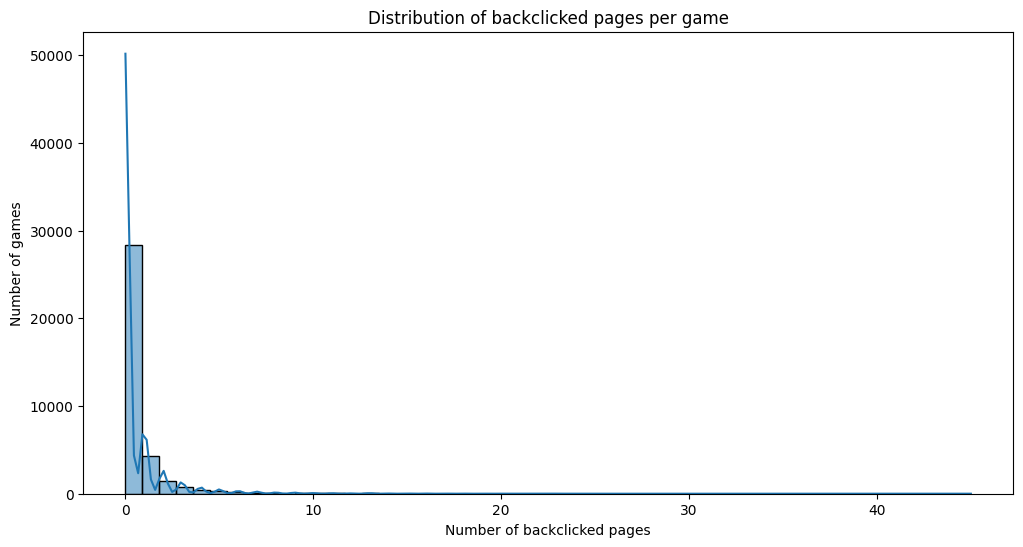

In [39]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=bck_an_all["backclicked_pages"].apply(
        lambda x: len(x) if x is not pd.NA else 0
    ),
    kde=True,
    bins=50,
)
plt.title("Distribution of backclicked pages per game")
plt.xlabel("Number of backclicked pages")
plt.ylabel("Number of games")
plt.show()

As we can see the distribution is highly skewed since most of the games have 0 or nearly 0 backclicked pages, but there are a few games with both a lot of visited and backclicked pages.


To analyze the impact of the backclicks on the likelyhood of quitting the game, we will then consider the **backclick frequency** per game, defined as the number of backclicked pages divided by the number of visited pages in that path.<br>
Let's visualize the back-click frequency distribution in two cases:
- first considering all the games independently
- then grouping and averaging back-click frequency of same player over multiple games

In [40]:
# Compute backclick frequency for each game as the number of backclicked pages divided by the number of visited pages
bck_an_all["backclick_number"] = bck_an_all["backclicked_pages"].apply(lambda x: len(x))
bck_an_all["visited_number"] = bck_an_all["visited_pages"].apply(lambda x: len(x))

bck_an_all["backclick_freq"] = (
    bck_an_all["backclick_number"] / bck_an_all["visited_number"]
)

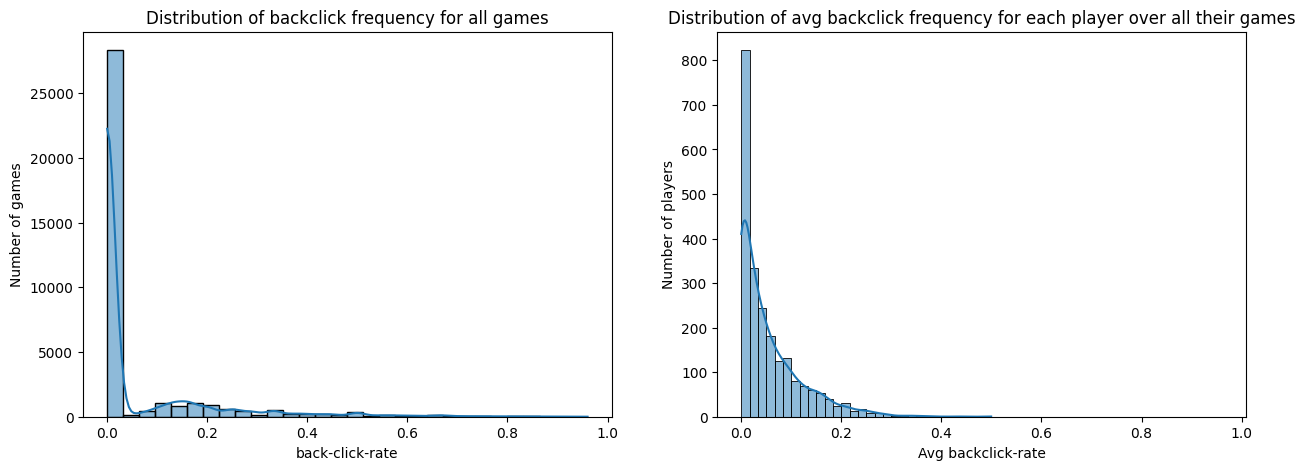

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

sns.histplot(data=bck_an_all["backclick_freq"], kde=True, bins=30, ax=axs[0])
axs[0].set_title("Distribution of backclick frequency for all games")
axs[0].set_xlabel("back-click-rate")
axs[0].set_ylabel("Number of games")

sns.histplot(
    data=bck_an_all[["hashedIpAddress", "backclick_freq"]]
    .groupby("hashedIpAddress")
    .mean()["backclick_freq"],
    kde=True,
    bins=30,
    ax=axs[1],
)
axs[1].set_title(
    "Distribution of avg backclick frequency for each player over all their games"
)
axs[1].set_xlabel("Avg backclick-rate")
axs[1].set_ylabel("Number of players")

plt.show()

This difference between the two distributions suggests that the use of backclicks is a characteristic of the player.

<a id=bck-freq-compare></a>
#### 2.4.2 Back-click frequency distribution in finished vs unfinished paths

Let's now compare the average backclick frequency distribution between finished and unfinished paths

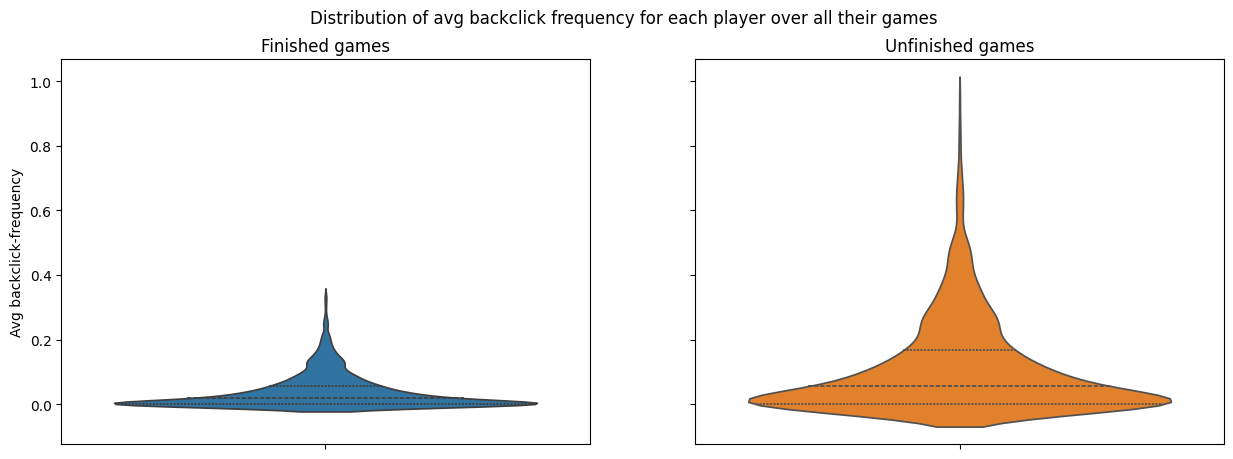

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)

sns.violinplot(
    bck_an_all[bck_an_all["finished"] == True]
    .groupby("hashedIpAddress")["backclick_freq"]
    .mean(),
    ax=axs[0],
    color=default_colors[0],
    inner="quart",
)
sns.violinplot(
    bck_an_all[bck_an_all["finished"] == False]
    .groupby("hashedIpAddress")["backclick_freq"]
    .mean(),
    ax=axs[1],
    color=default_colors[1],
    inner="quart",
)

fig.suptitle(
    "Distribution of avg backclick frequency for each player over all their games"
)
axs[0].set_title("Finished games")
axs[1].set_title("Unfinished games")
axs[0].set_ylabel("Avg backclick-frequency")

plt.show()

This violin plot shows how the average backclick frequency is often higher over unfinished paths, giving us the hint this parameter may be an indicator of a more likely quit of the player. <br>
Still we'll need further analysis (with a statistically significant test) to draw some more precise conclusions.

<a id=bck-rate-cat></a>
#### 2.4.3 Backclick rate per category

Do players backclick more frequently on some categories? Do things change if we consider only finished or unfinished paths?

To start exploring possible answers to these questions, let's define the **back-click rate per category** $c$ for a player $P$ as the number of times that $P$ has baclicked on a page that belongs to the category $c$, divide by the number of times $P$ visited a page of that category. This measure should express how likely is the player $P$ to back-click a page of category $c$.

In [43]:
# Create a dataframe to count the number of backclicks and visits for each category
bck_an_all["visited_categories"] = bck_an_all["visited_pages"].apply(
    lambda x: [
        article_to_broad_category[page][0]
        for page in x
        if page in article_to_broad_category.keys()
    ]
)
bck_an_all["backclicked_categories"] = bck_an_all["backclicked_pages"].apply(
    lambda x: [
        article_to_broad_category[page][0]
        for page in x
        if page in article_to_broad_category.keys()
    ]
    if x is not pd.NA
    else pd.NA
)

# Merge the two dataframes to count visits and backclicks per category
backclicks_per_category = pd.merge(
    bck_an_all[["hashedIpAddress", "visited_categories", "finished"]]
    .explode("visited_categories")
    .groupby(["hashedIpAddress", "visited_categories", "finished"])
    .size()
    .reset_index(name="visits_count"),
    bck_an_all[["hashedIpAddress", "backclicked_categories", "finished"]]
    .explode("backclicked_categories")
    .groupby(["hashedIpAddress", "backclicked_categories", "finished"])
    .size()
    .reset_index(name="backclicks_count"),
    how="left",
    left_on=["hashedIpAddress", "visited_categories", "finished"],
    right_on=["hashedIpAddress", "backclicked_categories", "finished"],
)

backclicks_per_category.drop(columns=["backclicked_categories"], inplace=True)
backclicks_per_category.rename(columns={"visited_categories": "category"}, inplace=True)
backclicks_per_category["backclicks_count"].fillna(0, inplace=True)
backclicks_per_category["backclick_rate_per_category"] = (
    backclicks_per_category["backclicks_count"]
    / backclicks_per_category["visits_count"]
)

/var/folders/vd/v1_75h5d54qdztdtkk73k1l80000gn/T/ipykernel_44852/51035596.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.4}` instead.

  sns.barplot(


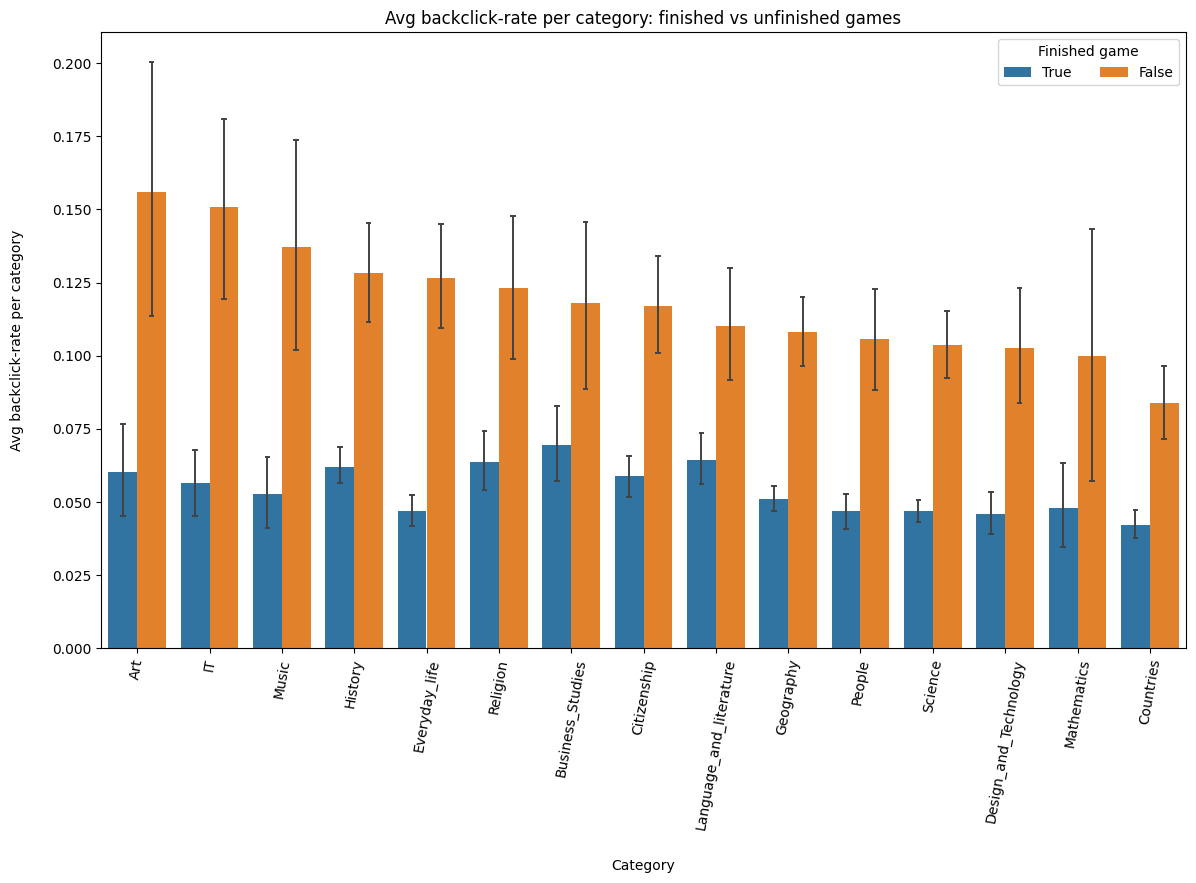

In [44]:
# Create a paired-column bar chart, showing for each category the average backclick-rate for finished and unfinished games
plt.figure(figsize=(14, 8))
sns.barplot(
    data=backclicks_per_category[
        ["category", "finished", "backclick_rate_per_category"]
    ],
    x="category",
    y="backclick_rate_per_category",
    hue="finished",
    order=backclicks_per_category[backclicks_per_category["finished"] == False][
        ["category", "backclick_rate_per_category"]
    ]
    .groupby("category")
    .mean()
    .sort_values(by="backclick_rate_per_category", ascending=False)
    .index,
    hue_order=[True, False],
    errorbar=("ci", 95),
    errwidth=1.4,
    capsize=0.1,
    estimator=np.mean,
)
plt.xticks(rotation=80)
plt.title("Avg backclick-rate per category: finished vs unfinished games")
plt.ylabel("Avg backclick-rate per category", labelpad=20)
plt.xlabel("Category", labelpad=20)
plt.legend(title="Finished game", ncols=2)
plt.show()

The bar chart shows that the average back-click rate is often significantly different for finished and unfinished paths.
Since this data compare finished and unfinished per-category backclicl-rate of all players, we could see that it's likely that a player with a high back-click rate will quit, even if the measure of how likely is this case, depends on the category.

<a id=bck-test></a>
#### 2.4.4 Backclick frequency impact on finishing the game

Let's get back to the starting point: is there a significant relationship between the backclick frequency over a game and the fact this game may have ended or not?

A first answer can be found by looking to the [**point biserial correlation**](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient), which is a correlation coefficient, mathematically equivalent to the Pearson correlation, specific for cases where we have one continouous variable and a dichotomous one. <br>
This setting fits our needs, in particular we can consider the following random variables:
- $X=\lbrace1 \text{ if the game is finished, } 0\text{ if the game is not finished}\rbrace$ $\implies$ dichotomous variable
- $Y=\text{backclick\_frequency}$ $\implies$ continuous variable

Let's first consider a simple case where all the different games are considered independently each other, so for this first analysis we won't group games played by the same user.

In [45]:
stats.pointbiserialr(x=bck_an_all["finished"], y=bck_an_all["backclick_freq"])

SignificanceResult(statistic=-0.18113366552996124, pvalue=8.646813407939963e-265)

We can already see a *small* negative correlation which is statistically significant. <br>
In particular, the fact that the correlation is negative already tells us that the higher the $\text{backclick\_frequency}$ the lower the probability of finishing the game $\Bbb{P}(X=1)$.

Let's now group data from different games of the same player, in particular, we'll take for each player it's average $\text{backclick\_frequency}$ over his/her finished games and over his/her unfinished games. <br>
By doing this we'll be able to tell whether there is a significant difference in the average backclick rate of each player, between his/her finished vs. unfinished games.

In [46]:
stats.pointbiserialr(
    x=bck_an_all.groupby(["hashedIpAddress", "finished"])["backclick_freq"]
    .mean()
    .reset_index()["finished"],
    y=bck_an_all.groupby(["hashedIpAddress", "finished"])["backclick_freq"]
    .mean()
    .reset_index()["backclick_freq"],
)

SignificanceResult(statistic=-0.334443873445089, pvalue=2.5920971008264735e-94)

This time the correlation is even higher (in absolute value) and still statistically significant, leading us to think that the backclick frequency of a player may be an indicator of likely quitting.

### 🤩 NEW: Analysis of categories usage
We compute for each player the vector $\underline{p}\in [0,1]^{\text{num. categories}}$ such that $p_i = \Bbb{P}(\text{"the player uses a page of category i"})$. <br>
We then try to use this vector to cluster all the players.


In [47]:
bck_an_all["quit_freq"] = bck_an_all.groupby("hashedIpAddress")["finished"].transform(
    lambda x: 1 - x.sum() / len(x)
)
bck_an_all

,hashedIpAddress,path,finished,target,backclicked_pages,visited_pages,backclick_number,visited_number,backclick_freq,visited_categories,backclicked_categories,quit_freq
0,3824310e536af032,"[14th_century, Europe, Africa, Atlantic_slave_...",True,African_slave_trade,[],"[14th_century, Europe, Africa, Atlantic_slave_...",0,5,0.000000,"[History, Geography, Geography, History, History]",[],0.350000
1,3824310e536af032,"[Bird, 19th_century, Germany, Adolf_Hitler]",True,Adolf_Hitler,[],"[Bird, 19th_century, Germany, Adolf_Hitler]",0,4,0.000000,"[Science, History, Countries, People]",[],0.350000
2,3824310e536af032,"[Brazil, Europe, Netherlands, Indonesia]",True,Indonesia,[],"[Brazil, Europe, Netherlands, Indonesia]",0,4,0.000000,"[Geography, Geography, Countries, Geography]",[],0.350000
3,3824310e536af032,"[Cereal, United_States, Music_of_the_United_St...",True,Kurt_Cobain,[],"[Cereal, United_States, Music_of_the_United_St...",0,6,0.000000,"[Everyday_life, Countries, Music, Music, Music...",[],0.350000
4,3824310e536af032,"[Dinosaur, Mongolia, China]",True,China,[],"[Dinosaur, Mongolia, China]",0,3,0.000000,"[Science, Geography, Geography]",[],0.350000
...,...,...,...,...,...,...,...,...,...,...,...,...
36224,109ed71f571d86e9,"[Pony, Ireland, Atlantic_Ocean, Arctic_Ocean, ...",False,Eskimo,[],"[Pony, Ireland, Atlantic_Ocean, Arctic_Ocean, ...",0,8,0.000000,"[Science, Countries, Geography, Geography, Geo...",[],0.341463
36225,109ed71f571d86e9,"[Montenegro, World_War_II, United_States, Cari...",False,Hurricane_Georges,[],"[Montenegro, World_War_II, United_States, Cari...",0,7,0.000000,"[Countries, History, Countries, Geography, Geo...",[],0.341463
36226,109ed71f571d86e9,"[Wine, Georgia_(country), Russia]",False,History_of_post-Soviet_Russia,[],"[Wine, Georgia_(country), Russia]",0,3,0.000000,"[Everyday_life, Countries, Countries]",[],0.341463
36227,109ed71f571d86e9,"[Turks_and_Caicos_Islands, United_States, Iraq...",False,Iraq_War,[],"[Turks_and_Caicos_Islands, United_States, Iraq...",0,6,0.000000,"[Geography, Countries, Countries, Citizenship,...",[],0.341463


In [48]:
# Copy the past dataframe that already contains the visited categories
cat_all = bck_an_all[["hashedIpAddress", "visited_categories", "quit_freq"]].copy()

# Explode over visited categories, group by player and category and count the number of visits per each category,
# then normalize over the total number of visits per player
cat_all = (
    cat_all.explode("visited_categories")
    .groupby(["hashedIpAddress", "visited_categories", "quit_freq"])
    .size()
    .reset_index(name="visits_count")
)

cat_all["visits_count"] = cat_all["visits_count"] / cat_all.groupby("hashedIpAddress")["visits_count"].transform("sum")

In [49]:
# Pivot and rename index
cat_all = cat_all.pivot(
        index=["hashedIpAddress", "quit_freq"], columns="visited_categories", values="visits_count"
    ).fillna(0).reset_index(
        names=["hashedIpAddress", "quit_freq"]
    )

In [50]:
# Cluster the players based on the categories they visited
data = cat_all.drop(columns=["hashedIpAddress", "quit_freq"]).to_numpy()
data

array([[0.        , 0.01724138, 0.17241379, ..., 0.01724138, 0.05172414,
        0.0862069 ],
       [0.        , 0.        , 0.        , ..., 0.01351351, 0.01351351,
        0.17567568],
       [0.02      , 0.        , 0.06      , ..., 0.12      , 0.        ,
        0.3       ],
       ...,
       [0.        , 0.        , 0.025     , ..., 0.05      , 0.075     ,
        0.15      ],
       [0.        , 0.        , 0.04      , ..., 0.08      , 0.        ,
        0.08      ],
       [0.02325581, 0.06976744, 0.02325581, ..., 0.02325581, 0.        ,
        0.41860465]])

In [51]:
# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)

# Reduce dimensionality for visualization
pca = PCA(n_components=3)
res = pca.fit_transform(data)

# Put the results in a dataframe
res_df = pd.DataFrame(res, columns=["x", "y", "z"])
res_df["cluster"] = kmeans.labels_
res_df["quit_freq"] = cat_all["quit_freq"]
res_df

/Users/mat/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x,y,z,cluster,quit_freq
0,-0.135543,-0.034070,0.088174,2,0.000000
1,-0.147936,0.089502,-0.137752,2,0.000000
2,0.112647,-0.071941,0.001018,3,0.166667
3,-0.110528,0.073807,0.038162,2,0.000000
4,0.195355,-0.089906,0.093811,3,0.466667
...,...,...,...,...,...
2252,-0.088644,0.043283,-0.054790,2,0.000000
2253,0.067159,0.125596,-0.048320,0,0.125000
2254,-0.010613,-0.150270,-0.027815,1,0.333333
2255,-0.175134,-0.066316,-0.055732,2,0.375000


In [52]:
fig = px.scatter_3d(res_df[res_df["cluster"] == 3].iloc[:200], x="x", y="y", z="z", symbol="cluster", color="quit_freq", opacity=0.3, width=1000, height=800)
fig.show()

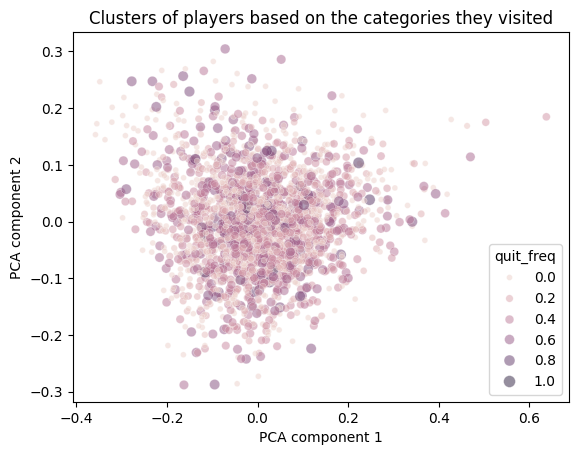

In [53]:
# Plot the clusters
sns.scatterplot(data=res_df, x="x", y="y", hue="quit_freq", alpha=0.5, size="quit_freq")
plt.title("Clusters of players based on the categories they visited")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()


In [54]:
formula="quit_freq ~ " + " + ".join(cat_all.columns[2:])

In [55]:
# Analyse whether the categories frequencies are a good predictor of the quit frequency
mod = smf.ols(formula="quit_freq ~ " + " + ".join(cat_all.columns[2:]), data=cat_all)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              quit_freq   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     9.323
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           2.42e-20
Time:                        11:54:38   Log-Likelihood:                 384.06
No. Observations:                2257   AIC:                            -738.1
Df Residuals:                    2242   BIC:                            -652.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### Semantic sim between articles

In [101]:
pers_finished_df, pers_unfinished_df = filter_games(
    finished_paths, unfinished_paths, min_games=0, min_length=3, type="restart"
)

# Concatenate the two filtered dataframes, adding a column to identify finished and unfinished paths
bck_an_all = pd.concat(
    [pers_finished_df.assign(finished=True), pers_unfinished_df.assign(finished=False)],
    ignore_index=True,
)[["hashedIpAddress", "path", "finished", "target"]]

# Compute backclicked pages (pages a "<" correponds to) and visited pages (path without the "<")
bck_an_all["backclicked_pages"] = bck_an_all["path"].apply(
    lambda x: get_backclicked_pages(x)
)
bck_an_all["visited_pages"] = bck_an_all["path"].apply(
    lambda x: [el for el in x if el != "<"]
)

15528 players played at least 0 games longer than 3 clicks.


In [103]:
semantic_df = bck_an_all[["hashedIpAddress", "finished", "path", "target"]].copy()

# Clean path removing the backclicks
semantic_df["path"] = semantic_df["path"].apply(lambda x: [el for el in x if el != "<"])


model = SentenceTransformer("all-MiniLM-L12-v2")

# Create a dictionary that stores the embedding of each page
# but these emebeddings are computed in batch
page_emb_dict = {}
pages = list(semantic_df["path"].explode().unique()) + list(semantic_df["target"].unique())

batch_size = 16

for i in range(0, len(pages), batch_size):
    page_emb_dict.update(dict(zip(pages[i:i+batch_size], model.encode(pages[i:i+batch_size], batch_size=batch_size, device="mps"))))

In [104]:
# Example
print("similarity between 14th_century and Apple = {}".format(float(cos_sim(page_emb_dict["14th_century"], page_emb_dict["Apple"]))))
print("similarity between Atlantic_slave_trade and United_States = {}".format(float(cos_sim(page_emb_dict["Atlantic_slave_trade"], page_emb_dict["United_States"]))))
print("similarity between Nazi_Germany and Adolf_Hitler = {}".format(float(cos_sim(page_emb_dict["Nazi_Germany"], page_emb_dict["Adolf_Hitler"]))))

similarity between 14th_century and Apple = 0.127338707447052
similarity between Atlantic_slave_trade and United_States = 0.40803784132003784
similarity between Nazi_Germany and Adolf_Hitler = 0.7845633029937744


In [105]:
# For each game compute the embedding of each visited page, store it in a list and add it to the dataframe
semantic_df["visited_pages_embeddings"] = semantic_df["path"].apply(
    lambda x: [page_emb_dict[page] for page in x]
)

semantic_df["target_embedding"] = semantic_df["target"].apply(lambda x: page_emb_dict[x])

In [106]:
semantic_df["path_sims"] = semantic_df["visited_pages_embeddings"].apply(
    lambda x: [float(cos_sim(x[i], x[i+1])) for i in range(len(x)-1)]
)

In [107]:
semantic_df["sims_to_target"] = semantic_df[["visited_pages_embeddings", "target_embedding"]].apply(
    lambda x: [float(cos_sim(x["visited_pages_embeddings"][i], x["target_embedding"])) for i in range(len(x["visited_pages_embeddings"]))],
    axis=1
)

In [108]:
semantic_df["avg_cons_sim"] = semantic_df["path_sims"].apply(lambda x: np.mean(x))
semantic_df["std_cons_sim"] = semantic_df["path_sims"].apply(lambda x: np.std(x))

semantic_df["avg_sim_from_target"] = semantic_df["sims_to_target"].apply(lambda x: np.mean(x))
semantic_df["std_sim_from_target"] = semantic_df["sims_to_target"].apply(lambda x: np.std(x))


semantic_df

,hashedIpAddress,finished,path,target,visited_pages_embeddings,target_embedding,path_sims,sims_to_target,avg_cons_sim,std_cons_sim,avg_sim_from_target,std_sim_from_target
0,6a3701d319fc3754,True,"[14th_century, 15th_century, 16th_century, Pac...",African_slave_trade,"[[-0.10277115, 0.08698267, -0.038366526, -0.11...","[-0.09715435, 0.017945217, -0.040928237, 0.020...","[0.8735459446907043, 0.8814976215362549, 0.150...","[0.2715170681476593, 0.2996854782104492, 0.287...",0.602492,0.282005,0.451758,0.270395
1,6a3701d319fc3754,True,"[Land_(economics), Economics, John_Maynard_Key...","Houston,_Texas","[[0.07849914, 0.07293369, 0.013559965, 0.01929...","[-0.011747076, -0.034741875, 0.03876537, 0.025...","[0.5665150284767151, 0.4068242311477661, 0.475...","[0.19807404279708862, 0.13887721300125122, 0.1...",0.422518,0.089808,0.369933,0.246378
2,6a3701d319fc3754,True,"[Sugar, Industrial_Revolution, Frankenstein]",Frankenstein,"[[-0.119014256, 0.017089691, 0.0120114, 0.0869...","[-0.045738045, 0.0034716087, 0.041058097, 0.02...","[0.16579598188400269, 0.20605386793613434]","[0.25763070583343506, 0.20605386793613434, 1.0...",0.185925,0.020129,0.487895,0.362725
3,6a3701d319fc3754,True,"[Thunderstorm, United_States, Puerto_Rico]",Puerto_Rico,"[[-0.039858717, 0.0018121125, -0.0305084, 0.03...","[-0.05039677, -0.02626284, 0.059931137, 0.0148...","[0.13998614251613617, 0.611867368221283]","[0.24053645133972168, 0.611867368221283, 1.000...",0.375927,0.235941,0.617468,0.310075
4,3824310e536af032,True,"[14th_century, Europe, Africa, Atlantic_slave_...",African_slave_trade,"[[-0.10277115, 0.08698267, -0.038366526, -0.11...","[-0.09715435, 0.017945217, -0.040928237, 0.020...","[0.39000147581100464, 0.6943676471710205, 0.37...","[0.2715170681476593, 0.2792528569698334, 0.516...",0.583618,0.208274,0.587460,0.300032
...,...,...,...,...,...,...,...,...,...,...,...,...
60999,109ed71f571d86e9,False,"[Pony, Ireland, Atlantic_Ocean, Arctic_Ocean, ...",Eskimo,"[[-0.0049000923, 0.037806645, 0.0012880489, 0....","[-0.055467557, 0.019351268, 0.064201996, 0.006...","[0.24250590801239014, 0.35363489389419556, 0.7...","[0.24248670041561127, 0.30520084500312805, 0.2...",0.562230,0.189576,0.324115,0.065985
61000,109ed71f571d86e9,False,"[Montenegro, World_War_II, United_States, Cari...",Hurricane_Georges,"[[-0.004440207, 0.019763444, -0.018305741, -0....","[-0.018838853, -0.0090636555, 0.0017850264, 0....","[0.2644021511077881, 0.3664737343788147, 0.377...","[0.15726833045482635, 0.264923095703125, 0.289...",0.494376,0.212174,0.421627,0.172737
61001,109ed71f571d86e9,False,"[Wine, Georgia_(country), Russia]",History_of_post-Soviet_Russia,"[[-0.03205836, -0.012625145, 0.00029549684, 0....","[-0.08218048, 0.04161655, -0.05326189, 0.02528...","[0.0879560187458992, 0.5712529420852661]","[0.13906678557395935, 0.3197568356990814, 0.59...",0.329604,0.241648,0.350428,0.186364
61002,109ed71f571d86e9,False,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,"[[0.031241948, -0.047082193, 0.022448076, 0.03...","[-0.06294676, -0.009791553, 0.003962395, -0.03...","[0.40301480889320374, 0.49936702847480774, 0.3...","[0.2993396520614624, 0.3686307966709137, 0.721...",0.436407,0.083657,0.479737,0.161477


In [109]:
# Add temporary column containing the progress of the game
semantic_df["progress"] = semantic_df["path"].apply(
    lambda x: np.arange(len(x)) / (len(x))
)
semantic_df

# Round all elements of the list inside "progress", with a precision of 0.05
semantic_df["progress_bin"] = semantic_df["progress"].apply(
    lambda x: [np.round(round(value / 0.1) * 0.1, 2) for value in x]
)

<Axes: xlabel='progress_bin', ylabel='sims_to_target'>

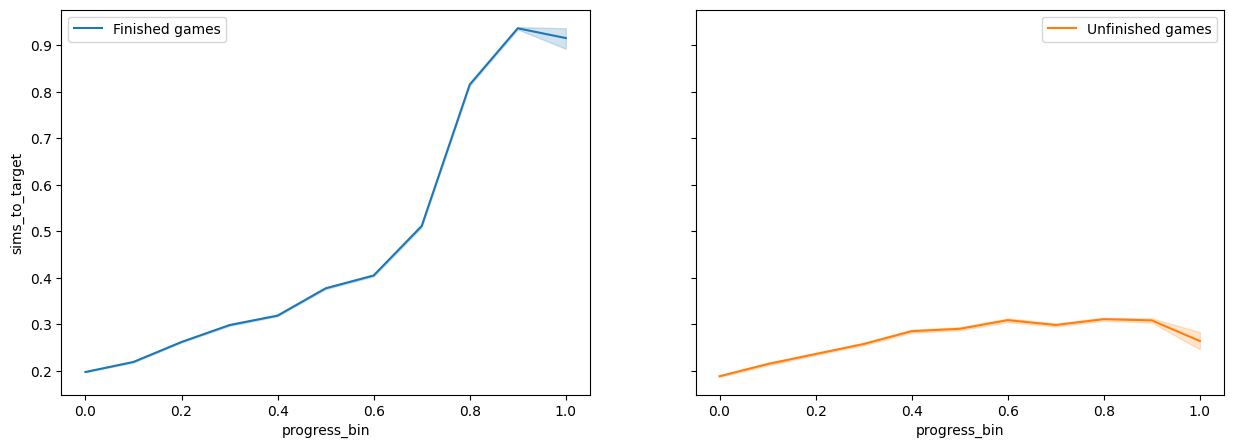

In [110]:
# Plot the simality towards the target vs. the progress_bin of the game
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

sns.lineplot(
    data=semantic_df[semantic_df["finished"] == True][["progress_bin", "sims_to_target"]].explode(["progress_bin", "sims_to_target"]),
    x="progress_bin",
    y="sims_to_target",
    ax=axs[0],
    color=default_colors[0],
    label="Finished games",
    errorbar=("ci", 95),
    estimator=np.mean,
    err_style="band",
)

sns.lineplot(
    data=semantic_df[semantic_df["finished"] == False][["progress_bin", "sims_to_target"]].explode(["progress_bin", "sims_to_target"]),
    x="progress_bin",
    y="sims_to_target",
    ax=axs[1],
    color=default_colors[1],
    label="Unfinished games",
    errorbar=("ci", 95),
    estimator=np.mean,
    err_style="band",
)

<Axes: xlabel='avg_sim_from_target', ylabel='Count'>

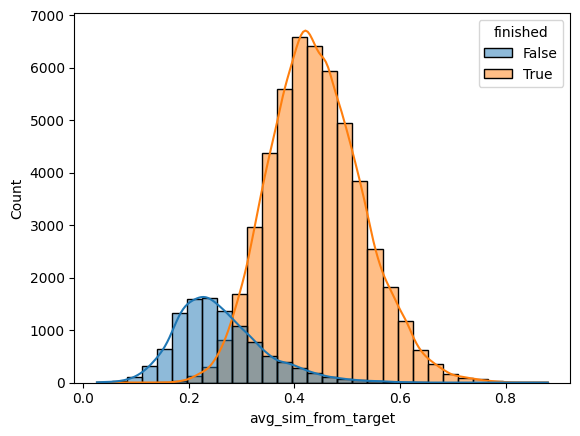

In [111]:
sns.histplot(data=semantic_df[["finished", "avg_sim_from_target"]], x="avg_sim_from_target", hue="finished", bins=30, kde=True, alpha=0.5)

In [ ]:
# The below code saves the version of the dataframe above:
finished_paths.to_pickle(
    os.path.join(GENERATED_METRICS, "finished_paths_initial_stats.pkl")
)
unfinished_paths.to_pickle(
    os.path.join(GENERATED_METRICS, "unfinished_paths_initial_stats.pkl")
)

In [ ]:
# The below code reads that version of the dataframe from the file:
finished_paths = pd.read_pickle(
    os.path.join(GENERATED_METRICS, "finished_paths_initial_stats.pkl")
)
unfinished_paths = pd.read_pickle(
    os.path.join(GENERATED_METRICS, "unfinished_paths_initial_stats.pkl")
)

<a id="everything"></a>

## 3 - Putting Everything Together: Logistic Regression
We build a Logistic Regression  to determine influencing factors on the propensity of a player to give up a game (restart or timeout). We combine all factors we have explored before to build a regression model to predict whether a player gives up to then interpret the coefficients

<a id="dataprep"></a>

#### 3.1 - Data Preparation

In [ ]:
## We first merge the article metrics (categories, word count etc.) to the finished and unfinished paths to create a dataset

# Merge and unfinished paths while adding a flag
finished_paths["give_up"] = 0
unfinished_paths["give_up"] = 1
games = pd.concat((finished_paths, unfinished_paths), axis=0)

# Drop duplicates in the article column, since one article might belong to more than one main category, some rows are duplicated. For now, we just drop these
article_metrics_with_categories = article_metrics_with_categories.drop_duplicates(
    subset="article"
)

# Define columns that may be relevant from article metrics:
# Some columns are exluded since they are contained in others, or because they are complements (stopword vs non-stopword percentage)
keep = [
    "article",
    "broad_category",
    "paragraph_count",
    "readability_score",
    "stopword_percentage",
    "avg_word_length",
    "avg_sent_length",
]

# Merge on start
start_metrics = article_metrics_with_categories[keep].add_prefix("start_")
games = pd.merge(
    games, start_metrics, how="left", left_on="start", right_on="start_article"
)  # add prefix
print(games.shape)  # check results of the merge

# Merge on target
target_metrics = article_metrics_with_categories[keep].add_prefix("target_")
games = pd.merge(
    games, target_metrics, how="left", left_on="target", right_on="target_article"
)  # add prefix
print(games.shape)  # check results of the merge

# Subset games to only include those with reasonable path lengths - TBD, no filtering for now
# games = games[(games.path_length > 1) & (games.path_length < 30)]


# remove unnecessary columns
to_drop = [
    "hashedIpAddress",
    "timestamp",
    "durationInSec",
    "path",
    "rating",
    "datetime",
    "start",
    "target",
    "path_length",
    "target_article",
    "start_article",
    "type",
]
games = games.drop(to_drop, axis=1)
print(games.shape)  # check results of the subsetting

In [ ]:
percent_missing = games.isnull().sum() * 100 / len(games)
display(percent_missing)

In [ ]:
# Drop all NAs - for the actual analysis we need to investigate more why these are coming from.
# For this proof of concept we just remove them
games = games.dropna(axis=0, how="any")
display(games)

<a id="log_reg_all"></a>

#### 3.2 - Logistic Regression with all Predictors

In [ ]:
# Create formula for logistic regression
target = "give_up"
predictors = [col for col in games.columns if col != target]
formula = target + " ~ " + " + ".join(predictors)
print(formula)

In [ ]:
# Logistic regression model with the full formula (i.e. all relevant predictors)
mod = smf.logit(formula=formula, data=games)
res = mod.fit(maxiter=30)
print(res.summary())

<a id="log_reg_subset"></a>

#### 3.3 - Logistic Regression with predictors known to player before the game
we exclude anything not visible to the player at the start (e.g., the article metrics of the target article)

In [ ]:
# Regression model with limited predictors: only those visible to a player at the start of the game
formula = "give_up ~ links_to_target + shortest_path_length + start_broad_category + start_paragraph_count + start_readability_score + start_stopword_percentage + start_avg_sent_length + C(target_broad_category)"
mod = smf.logit(formula=formula, data=games)
res = mod.fit(maxiter=30)
print(res.summary())

The two regression models are largely congruent and offer some interesting initial findings (non-exhaustive):
- some categories have a large and statistically significant influence on the proabability of a player giving up. A few examples:
    - paths starting from *language and literature* or more niche topics like *Design and Technology* increase the propensity to give up
    - a target article in the categories *Geography* or *Countries* strongly decreases the probability. This is consistent with the hypothesis that these are rather "easy" categories, as many links point to them.
- similarly, many of the article related metrics are statistically significant; for instance:
    - the shortest_path_length has a large positive coefficient, indicating that objectively longer paths do lead to more failures
    - more detailed article metrics are statistically relevant, but the effect sizes are quite small (e.g., in-degree of target, readability score etc.)

**Caveat:** Input features need to be standardized for easier interpretability and comparison. This will be done for P3.